# Weather Data Analysis with PySpark

This notebook was completed as part of the UCSD MicroMasters on edx.

## Climate data

The data used here comes from NOAA. Specifically, it was downloaded from this FTP site: https://www.ngdc.noaa.gov/ftp.html. It contains a large variety of measurements from all over the world, from 1870 to 2012. 

To get spark to work, I followed these instructions:
https://towardsdatascience.com/how-to-use-pyspark-on-your-computer-9c7180075617
https://mas-dse.github.io/DSE230/installation/linux/

In [1]:
import findspark
findspark.init()

In [2]:
import numpy as np

In [3]:
from pyspark import SparkContext,SparkConf

def create_sc(pyFiles):
    sc_conf = SparkConf()
    sc_conf.setAppName("Weather_PCA")
    sc_conf.set('spark.executor.memory', '3g')
    sc_conf.set('spark.executor.cores', '1')
    sc_conf.set('spark.cores.max', '4')
    sc_conf.set('spark.default.parallelism','10')
    sc_conf.set('spark.logConf', True)
    print(sc_conf.getAll())

    sc = SparkContext(conf=sc_conf,pyFiles=pyFiles)

    return sc 

sc = create_sc(pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStatistics.py'])

dict_items([('spark.app.name', 'Weather_PCA'), ('spark.executor.memory', '3g'), ('spark.executor.cores', '1'), ('spark.cores.max', '4'), ('spark.default.parallelism', '10'), ('spark.logConf', 'True')])


In [4]:
from pyspark.sql import *
sqlContext = SQLContext(sc)

import numpy as np
from lib.computeStatistics import *

### Data cleaning

    Most measurements exist for only a tiny fraction of the stations and years. Therefore, use is restricted to the following measurements:

    ['TMAX', 'SNOW', 'SNWD', 'TMIN', 'PRCP', 'TOBS']

    Only measurement-years that have at most 50 NaN entries are considered here

    Only measurements in the continential USA are considered here

    The stations are partitioned into the states of the continental USA (plus a few stations from states in Canada and Mexico).

In [5]:
state = 'NY'
data_dir = 'Data/Weather'
tarname = state+'.tgz'
parquet = state+'.parquet'
    
%mkdir -p $data_dir
!rm -rf $data_dir/$tarname

command = "curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/%s > %s/%s"%(tarname,data_dir,tarname)
print(command)
!$command
!ls -lh $data_dir/$tarname

cur_dir,=!pwd
%cd $data_dir
!tar -xzf $tarname
!du ./$parquet
%cd $cur_dir

curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/NY.tgz > Data/Weather/NY.tgz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63.2M  100 63.2M    0     0  2476k      0  0:00:26  0:00:26 --:--:-- 3102k
-rw-r--r--  1 charlottefettes  staff    63M 19 Feb 14:44 Data/Weather/NY.tgz
/Users/charlottefettes/Documents/Data_Science_Projects/Spark_Data_Analysis/Data/Weather
155648	./NY.parquet
/Users/charlottefettes/Documents/Data_Science_Projects/Spark_Data_Analysis


In [6]:
parquet_path = data_dir+'/'+parquet
!du -sh $parquet_path

 76M	Data/Weather/NY.parquet


In [7]:
%%time
df = sqlContext.read.parquet(parquet_path)
print(df.count())
df.show(5)

168398
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
|    Station|Measurement|Year|              Values|       dist_coast|      latitude|         longitude|        elevation|state|             name|
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
|USW00094704|   PRCP_s20|1945|[00 00 00 00 00 0...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1946|[99 46 52 46 0B 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1947|[79 4C 75 4C 8F 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1948|[72 48 7A 48 85 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517

In [8]:
sqlContext.registerDataFrameAsTable(df,'table')

In [9]:
Query="""
SELECT Measurement,count(Measurement) as count 
FROM table 
GROUP BY Measurement
ORDER BY count
"""
counts = sqlContext.sql(Query)
counts.show()

+-----------+-----+
|Measurement|count|
+-----------+-----+
|       TOBS|10956|
|   TOBS_s20|10956|
|       TMAX|13437|
|   TMAX_s20|13437|
|   TMIN_s20|13442|
|       TMIN|13442|
|       SNWD|14617|
|   SNWD_s20|14617|
|   SNOW_s20|15629|
|       SNOW|15629|
|   PRCP_s20|16118|
|       PRCP|16118|
+-----------+-----+



In [10]:
from time import time
t = time()

N = sc.defaultParallelism
print('Number of executors=',N)
print('took', time()-t, 'seconds')

Number of executors= 10
took 0.0010530948638916016 seconds


In [11]:
!ls lib

MultiPlot.py            computeStatistics.py    row_parser.py
Reconstruction_plots.py decomposer.py           spark_PCA.py
YearPlotter.py          getFiles.py             spark_PCA_HW.py
__init__.py             import_modules.py       tmp
__pycache__             leaflet.py
binary_search.py        numpy_pack.py


In [12]:
#%load lib/spark_PCA.py
import numpy as np
from numpy import linalg as LA

def outerProduct(X):
    """Computer outer product and indicate which locations in matrix are undefined"""
    O = np.outer(X,X)
    N = 1-np.isnan(O)
    return (O,N)

def sumWithNan(M1,M2):
    """Add two pairs of (matrix,count)"""
    (X1,N1) = M1
    (X2,N2) = M2
    N = N1+N2
    X = np.nansum(np.dstack((X1,X2)),axis=2)
    return (X,N)

def HW_func(S,N):
    E = S[0,1::]/1  #E is the sum of the vectors
    NE = N[0,1::]/1  #NE is the number of not-nan entries for each coordinate of the vectors
    Mean = E/NE  #Mean is the Mean vector (ignoring nans)
    O = S[1::,1::]/1  # O is the sum of the outer products
    NO = N[1::,1::]/1  # NO is the number of non-nans in the outer product.
    
    return E, NE, Mean, O, NO

In [13]:
def computeCov(RDDin):
    """computeCov recieves as input an RDD of np arrays, all of the same length, 
    and computes the covariance matrix for that set of vectors"""
    RDD = RDDin.map(lambda v:np.array(np.insert(v,0,1),dtype=np.float64)) #insert a 1 at the beginning of each vector so that the same 
                                           #calculation also yields the mean vector
    OuterRDD = RDD.map(outerProduct)   #separating the map and the reduce does not matter as Spark uses lazy execution
    (S,N) = OuterRDD.reduce(sumWithNan)

    E,NE,Mean,O,NO = HW_func(S,N)

    Cov = O/NO - np.outer(Mean,Mean)
    # Output also the diagnal which is the variance for each day
    Var = np.array([Cov[i,i] for i in range(Cov.shape[0])])
    return {'E':E,'NE':NE,'O':O,'NO':NO,'Cov':Cov,'Mean':Mean,'Var':Var}

In [14]:
if __name__=="__main__":
    #create synthetic data matrix with j rows and rank k
    
    V = 2*(np.random.random([2,10])-0.5)
    data_list = []
    for i in range(1000):
        f = 2*(np.random.random(2)-0.5)
        data_list.append(np.dot(f,V))
    #compute covariance matrix
    RDD = sc.parallelize(data_list)
    OUT = computeCov(RDD)

    #find PCA decomposition
    eigval,eigvec = LA.eig(OUT['Cov'])
    print('eigval=',eigval)
    print('eigvec=',eigvec)

eigval= [ 1.58015950e+00 -5.55111512e-17  7.65495410e-01  6.54846485e-17
 -1.26943085e-16  4.44404765e-17  2.50746592e-17 -7.50748755e-17
 -3.17497097e-17 -4.76174554e-17]
eigvec= [[-0.45719807 -0.81038516  0.36639571  0.19574045  0.21101222 -0.29781693
  -0.12376545  0.09051241 -0.03919197 -0.43359643]
 [ 0.13892306  0.12895293  0.45856678 -0.5381982   0.00564774  0.33190654
  -0.0543616   0.13267809  0.22359542  0.04928152]
 [ 0.32263172 -0.0388729   0.3166101   0.01617029 -0.71830593  0.0663386
   0.14392123 -0.13336144 -0.24583263 -0.07701236]
 [ 0.31732783 -0.05433086  0.27580222  0.32558739  0.0500881  -0.21318958
  -0.06152929  0.71728249  0.22058335  0.12326743]
 [-0.18260067  0.05597291 -0.10405433  0.04036548  0.01625603  0.0874531
  -0.20223171  0.23954493 -0.49566188 -0.12407558]
 [-0.42241363  0.34419982  0.23419413 -0.48690187  0.06013329  0.72009294
   0.70051359 -0.13831494  0.32883009  0.56595106]
 [-0.22434782 -0.02504863 -0.33534897  0.02838403 -0.12046502  0.1253318

In [15]:
%%writefile lib/tmp
# %load lib/computeStatistics.py

from numpy import linalg as LA
import numpy as np

from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from time import time

def computeStatistics(sqlContext,df):
    """Compute all statistics for a given dataframe
    Input: sqlContext: to perform SQL queries
            df: dataframe with the fields 
            Station(string), Measurement(string), Year(integer), Values (byteArray with 365 float16 numbers)
    returns: STAT, a dictionary of dictionaries. First key is measurement, 
             second keys described in computeStats.STAT_Descriptions
    """

    sqlContext.registerDataFrameAsTable(df,'weather')
    STAT = {}  #dictionary storing statistics for each measurement
    measurements = ['TMAX', 'SNOW', 'SNWD', 'TMIN', 'PRCP', 'TOBS']
    
    for meas in measurements:
        t = time()
        Query = "SELECT * FROM weather\n\tWHERE measurement = '%s'"%(meas)
        mdf = sqlContext.sql(Query)
        print(meas,': shape of mdf is ',mdf.count())

        data = mdf.rdd.map(lambda row: unpackArray(row['Values'],np.float16))

        #compute basic statistics
        STAT[meas] = computeOverAllDist(data)   #compute statistics 

        #compute covariance matrix
        OUT = computeCov(data)

        #find PCA decomposition
        eigval,eigvec = LA.eig(OUT['Cov'])

        #collect all statistics in STAT[meas]
        STAT[meas]['eigval'] = eigval
        STAT[meas]['eigvec'] = eigvec
        STAT[meas].update(OUT)

        print('time for',meas,'is',time()-t)
    
    return STAT

#compute overall distribution of values and distribution of number of nan per year
def find_percentiles(SortedVals,percentile):
    L = int(len(SortedVals)/percentile)
    return SortedVals[L],SortedVals[-L]
  
def computeOverAllDist(rdd0):
    UnDef = np.array(rdd0.map(lambda row:sum(np.isnan(row))).sample(False,0.01).collect())
    flat = rdd0.flatMap(lambda v:list(v)).filter(lambda x: not np.isnan(x)).cache()
    count, S1, S2 = flat.map(lambda x: np.float64([1,x,x**2])).reduce(lambda x,y: x+y)
    mean = S1/count
    std = np.sqrt(S2/count-mean**2)
    Vals = flat.sample(False,0.0001).collect()
    SortedVals = np.array(sorted(Vals))
    low100,high100 = find_percentiles(SortedVals,100)
    low1000,high1000 = find_percentiles(SortedVals,1000)
    return {'UnDef':UnDef,\
          'mean':mean,\
          'std':std,\
          'SortedVals':SortedVals,\
          'low100':low100,\
          'high100':high100,\
          'low1000':low100,\
          'high1000':high1000
          }

#description of data returned by computeOverAllDist
STAT_Descriptions = [
('SortedVals', 'Sample of values', 'vector whose length varies between measurements'),
 ('UnDef', 'sample of number of undefs per row', 'vector whose length varies between measurements'),
 ('mean', 'mean value', ()),
 ('std', 'std', ()),
 ('low100', 'bottom 1%', ()),
 ('high100', 'top 1%', ()),
 ('low1000', 'bottom 0.1%', ()),
 ('high1000', 'top 0.1%', ()),
 ('E', 'Sum of values per day', (365,)),
 ('NE', 'count of values per day', (365,)),
 ('Mean', 'E/NE', (365,)),
 ('O', 'Sum of outer products', (365, 365)),
 ('NO', 'counts for outer products', (365, 365)),
 ('Cov', 'O/NO', (365, 365)),
 ('Var', 'The variance per day = diagonal of Cov', (365,)),
 ('eigval', 'PCA eigen-values', (365,)),
 ('eigvec', 'PCA eigen-vectors', (365, 365))
]

Overwriting lib/tmp


In [16]:
%%time 

#main cell where all of statistics computed
STAT = computeStatistics(sqlContext,df)

TMAX : shape of mdf is  13437
time for TMAX is 32.60162091255188
SNOW : shape of mdf is  15629
time for SNOW is 39.24459409713745
SNWD : shape of mdf is  14617
time for SNWD is 35.14591407775879
TMIN : shape of mdf is  13442
time for TMIN is 34.37323784828186
PRCP : shape of mdf is  16118
time for PRCP is 40.5783576965332
TOBS : shape of mdf is  10956
time for TOBS is 27.92244601249695
CPU times: user 5.01 s, sys: 269 ms, total: 5.28 s
Wall time: 3min 29s


In [17]:
print("   Name  \t                 Description             \t  Size")
print("-"*80)
print('\n'.join(["%10s\t%40s\t%s"%(s[0],s[1],str(s[2])) for s in STAT_Descriptions]))

   Name  	                 Description             	  Size
--------------------------------------------------------------------------------
SortedVals	                        Sample of values	vector whose length varies between measurements
     UnDef	      sample of number of undefs per row	vector whose length varies between measurements
      mean	                              mean value	()
       std	                                     std	()
    low100	                               bottom 1%	()
   high100	                                  top 1%	()
   low1000	                             bottom 0.1%	()
  high1000	                                top 0.1%	()
         E	                   Sum of values per day	(365,)
        NE	                 count of values per day	(365,)
      Mean	                                    E/NE	(365,)
         O	                   Sum of outer products	(365, 365)
        NO	               counts for outer products	(365, 365)
       Cov	                

In [18]:
#dump STAT and STST_Descriptions into a pickle file
from pickle import dump

filename=data_dir+'/STAT_%s.pickle'%state
dump((STAT,STAT_Descriptions),open(filename,'wb'))
!ls -l $data_dir

total 184648
drwxr-xr-x  2374 charlottefettes  staff     75968 19 Feb 14:43 Joined_smoothed_PRCP.parquet
drwxr-xr-x    31 charlottefettes  staff       992 19 Feb 14:44 NY.parquet
-rw-r--r--     1 charlottefettes  staff  66288146 19 Feb 14:44 NY.tgz
-rw-r--r--     1 charlottefettes  staff  25684742 19 Feb 14:48 STAT_NY.pickle
-rw-r--r--@    1 charlottefettes  staff    731305 18 Feb 18:13 US_stations.tsv
-rw-r--r--     1 charlottefettes  staff    353056 18 Feb 18:00 Weather_Stations.tgz
drwxr-xr-x     8 charlottefettes  staff       256 19 Feb 14:42 decon_NY_PRCP_s20.parquet
drwxr-xr-x    10 charlottefettes  staff       320 19 Feb 14:42 decon_NY_SNWD.parquet
drwxr-xr-x    10 charlottefettes  staff       320 19 Feb 14:42 recon_NY_SNWD.parquet
drwxr-xr-x     9 charlottefettes  staff       288 19 Feb 14:42 stations.parquet


In [19]:
X = STAT['TMAX']['Var']
for key in STAT.keys():
    Y = STAT[key]['Var']
    print(key, sum(abs(X-Y)))

TMAX 0.0
SNOW 0.0
SNWD 0.0
TMIN 0.0
PRCP 0.0
TOBS 0.0


In [20]:
!ls -l Data/Weather/STAT*

-rw-r--r--  1 charlottefettes  staff  25684742 19 Feb 14:48 Data/Weather/STAT_NY.pickle


In [21]:
!gzip -f -k Data/Weather/STAT*.pickle
!ls -l Data/Weather/STAT*

-rw-r--r--  1 charlottefettes  staff  25684742 19 Feb 14:48 Data/Weather/STAT_NY.pickle
-rw-r--r--  1 charlottefettes  staff     49296 19 Feb 14:48 Data/Weather/STAT_NY.pickle.gz


## Weather Data: Initial Visualisation
### For New York State

In [22]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStatistics.py'])

from pyspark import SparkContext
from pyspark.sql import *
import pyspark.sql
sqlContext = SQLContext(sc)

import numpy as np
from lib.numpy_pack import packArray,unpackArray
from lib.spark_PCA import computeCov
from lib.computeStatistics import *

Populating the interactive namespace from numpy and matplotlib


/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [23]:
import warnings 
warnings.filterwarnings('ignore')

_figsize=(10,7)

### Read Data
Read Raw data for state

In [24]:
state='NY'
data_dir='Data/Weather'

tarname=state+'.tgz'
parquet=state+'.parquet'

%mkdir -p $data_dir
!rm -rf $data_dir/$tarname

command="curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/%s > %s/%s"%(tarname,data_dir,tarname)
print(command)
!$command
!ls -lh $data_dir/$tarname

curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/NY.tgz > Data/Weather/NY.tgz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63.2M  100 63.2M    0     0  3756k      0  0:00:17  0:00:17 --:--:-- 4248k
-rw-r--r--  1 charlottefettes  staff    63M 19 Feb 14:48 Data/Weather/NY.tgz


In [25]:
!ls $data_dir

Joined_smoothed_PRCP.parquet Weather_Stations.tgz
NY.parquet                   decon_NY_PRCP_s20.parquet
NY.tgz                       decon_NY_SNWD.parquet
STAT_NY.pickle               recon_NY_SNWD.parquet
STAT_NY.pickle.gz            stations.parquet
US_stations.tsv


In [26]:
cur_dir,=!pwd
%cd $data_dir
!tar -xzf $tarname
!du ./$parquet
%cd $cur_dir

/Users/charlottefettes/Documents/Data_Science_Projects/Spark_Data_Analysis/Data/Weather
155648	./NY.parquet
/Users/charlottefettes/Documents/Data_Science_Projects/Spark_Data_Analysis


In [27]:
!du -h $data_dir/$parquet

 76M	Data/Weather/NY.parquet


In [28]:
print(parquet)
weather_df=sqlContext.read.parquet(data_dir+'/'+parquet)
#weather_df=weather_df.drop('State') # we drop State because it already exists in "Stations".

NY.parquet


In [29]:
%%time
weather_df.count()

CPU times: user 692 µs, sys: 1.05 ms, total: 1.74 ms
Wall time: 80.7 ms


168398

In [30]:
print('number of rows=',weather_df.cache().count())
weather_df.show(5)

number of rows= 168398
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
|    Station|Measurement|Year|              Values|       dist_coast|      latitude|         longitude|        elevation|state|             name|
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
|USW00094704|   PRCP_s20|1945|[00 00 00 00 00 0...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1946|[99 46 52 46 0B 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1947|[79 4C 75 4C 8F 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1948|[72 48 7A 48 85 4...|361.8320007324219|42.57080078125|-77.7133026123046

### Read statistics information for state.

In [31]:
#read statistics
filename='STAT_%s.pickle'%state
command="curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/%s.gz > %s/%s.gz"%(filename,data_dir,filename)
print(command)
!$command

curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/STAT_NY.pickle.gz > Data/Weather/STAT_NY.pickle.gz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29.9M  100 29.9M    0     0  3301k      0  0:00:09  0:00:09 --:--:-- 3893k      0  0:00:09  0:00:06  0:00:03 4115k


In [32]:
gzpath='%s/%s.gz'%(data_dir,filename)
print(gzpath)
!ls -l $gzpath
!gunzip -f $gzpath

Data/Weather/STAT_NY.pickle.gz
-rw-r--r--  1 charlottefettes  staff  31373293 19 Feb 14:48 Data/Weather/STAT_NY.pickle.gz


In [33]:
STAT,STAT_Descriptions = load(open(data_dir+'/'+filename,'rb'), allow_pickle=True)
print('keys from STAT=',STAT.keys())

keys from STAT= dict_keys(['SNOW_s20', 'TMIN_s20', 'TOBS', 'SNWD_s20', 'PRCP_s20', 'TOBS_s20', 'PRCP', 'TMAX', 'TMAX_s20', 'TMIN', 'SNOW', 'SNWD'])


In [34]:
print("   Name  \t                 Description             \t  Size")
print("-"*80)
print('\n'.join(["%10s\t%40s\t%s"%(s[0],s[1],str(s[2])) for s in STAT_Descriptions]))

   Name  	                 Description             	  Size
--------------------------------------------------------------------------------
SortedVals	                        Sample of values	vector whose length varies between measurements
     UnDef	      sample of number of undefs per row	vector whose length varies between measurements
      mean	                              mean value	()
       std	                                     std	()
    low100	                               bottom 1%	()
   high100	                                  top 1%	()
   low1000	                             bottom 0.1%	()
  high1000	                                top 0.1%	()
         E	                   Sum of values per day	(365,)
        NE	                 count of values per day	(365,)
      Mean	                                    E/NE	(365,)
         O	                   Sum of outer products	(365, 365)
        NO	               counts for outer products	(365, 365)
       Cov	                

### Read information about US weather stations.

In [35]:
filename='Weather_Stations.tgz'
parquet='stations.parquet'
command="curl https://mas-dse-open.s3.amazonaws.com/Weather/%s > %s/%s"%(filename,data_dir,filename)
print(command)
!$command

curl https://mas-dse-open.s3.amazonaws.com/Weather/Weather_Stations.tgz > Data/Weather/Weather_Stations.tgz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  344k  100  344k    0     0   246k      0  0:00:01  0:00:01 --:--:--  246k


In [36]:
%cd $data_dir
!tar -xzf $filename
!du -s *.parquet
%cd $cur_dir

/Users/charlottefettes/Documents/Data_Science_Projects/Spark_Data_Analysis/Data/Weather
210152	Joined_smoothed_PRCP.parquet
155648	NY.parquet
26200	decon_NY_PRCP_s20.parquet
3840	decon_NY_SNWD.parquet
3840	recon_NY_SNWD.parquet
832	stations.parquet
/Users/charlottefettes/Documents/Data_Science_Projects/Spark_Data_Analysis


In [37]:
stations_df =sqlContext.read.parquet(data_dir+'/'+parquet)
stations_df.show(5)

+-----------+----------+--------+---------+---------+-----+----------------+
|    Station|Dist_coast|Latitude|Longitude|Elevation|State|            Name|
+-----------+----------+--------+---------+---------+-----+----------------+
|USC00341900|   739.956|    36.3| -96.4667|    242.3|   OK|       CLEVELAND|
|USC00428114|    908.22|    40.1|-111.6667|   1409.1|   UT|SPANISH FORK 1 S|
|USC00165926|   23.8801| 29.7853| -90.1158|      0.9|   LA|   MARRERO 9 SSW|
|USC00411974|   541.905| 31.5333|-101.2842|    755.9|   TX|        COPE RCH|
|USC00318906|   310.311| 35.5231| -81.4439|    274.3|   NC|    VALE AG 2 SW|
+-----------+----------+--------+---------+---------+-----+----------------+
only showing top 5 rows



In [38]:
weather_df=weather_df#.drop('name').drop('dist_coast')
weather_df.show(3)

+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
|    Station|Measurement|Year|              Values|       dist_coast|      latitude|         longitude|        elevation|state|             name|
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
|USW00094704|   PRCP_s20|1945|[00 00 00 00 00 0...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1946|[99 46 52 46 0B 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1947|[79 4C 75 4C 8F 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+---

In [39]:
jdf=weather_df.join(stations_df,on='Station',how='left')
jdf.show(3)
jdf.columns

+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+----------+--------+---------+---------+-----+-----------------+
|    Station|Measurement|Year|              Values|       dist_coast|      latitude|         longitude|        elevation|state|             name|Dist_coast|Latitude|Longitude|Elevation|State|             Name|
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+----------+--------+---------+---------+-----+-----------------+
|USW00094704|   PRCP_s20|1945|[00 00 00 00 00 0...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|   361.832| 42.5708| -77.7133|    208.8|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1946|[99 46 52 46 0B 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|   361.832| 42.

['Station',
 'Measurement',
 'Year',
 'Values',
 'dist_coast',
 'latitude',
 'longitude',
 'elevation',
 'state',
 'name',
 'Dist_coast',
 'Latitude',
 'Longitude',
 'Elevation',
 'State',
 'Name']

In [40]:
sqlContext.registerDataFrameAsTable(weather_df,'jdf')

#find stations in NY with the most measurements
sqlContext.sql('select name,count(name) as count from jdf group by name order by count desc').show(5)
#GROUP BY name ORDER BY count').show(5)

+--------------------+-----+
|                name|count|
+--------------------+-----+
|     SETAUKET STRONG| 1438|
|NEW YORK CNTRL PK...| 1430|
|            LOWVILLE| 1410|
|              ELMIRA| 1408|
|            ANGELICA| 1406|
+--------------------+-----+
only showing top 5 rows



In [41]:
#find how many measurements of each type for a particular station
stat='ELMIRA'
Query="""
SELECT Measurement,count(Measurement) as count 
FROM jdf 
WHERE Name='%s' 
GROUP BY Measurement
"""%stat
sqlContext.sql(Query).show()

+-----------+-----+
|Measurement|count|
+-----------+-----+
|   TMIN_s20|  120|
|       TMIN|  120|
|   SNOW_s20|  121|
|       TOBS|  113|
|   SNWD_s20|  109|
|   TOBS_s20|  113|
|   PRCP_s20|  121|
|       TMAX|  120|
|       SNOW|  121|
|   TMAX_s20|  120|
|       SNWD|  109|
|       PRCP|  121|
+-----------+-----+



In [42]:
#find year with all 6 measurements
Query="""
SELECT Year,count(Year) as count 
FROM jdf 
WHERE Name='%s' 
GROUP BY Year
ORDER BY count DESC
"""%stat
sqlContext.sql(Query).show(5)

+----+-----+
|Year|count|
+----+-----+
|1950|   12|
|1919|   12|
|1936|   12|
|1951|   12|
|1921|   12|
+----+-----+
only showing top 5 rows



In [43]:
#get all measurements for a particular year and a particular station
year=2007
Query="""
SELECT *
FROM jdf 
WHERE Name='%s' 
and Year=%d
"""%(stat,year )
pandas_df=sqlContext.sql(Query).toPandas()
pandas_df=pandas_df.set_index('Measurement')
pandas_df

Station  Year  \
Measurement                      
SNOW_s20     USC00302610  2007   
SNWD_s20     USC00302610  2007   
TOBS_s20     USC00302610  2007   
PRCP_s20     USC00302610  2007   
TMAX_s20     USC00302610  2007   
TMIN_s20     USC00302610  2007   
PRCP         USC00302610  2007   
SNOW         USC00302610  2007   
SNWD         USC00302610  2007   
TMAX         USC00302610  2007   
TMIN         USC00302610  2007   
TOBS         USC00302610  2007   

                                                        Values  dist_coast  \
Measurement                                                                  
SNOW_s20     [102, 61, 227, 61, 128, 62, 17, 63, 170, 63, 7...  272.682007   
SNWD_s20     [170, 70, 121, 71, 48, 72, 170, 72, 45, 73, 19...  272.682007   
TOBS_s20     [85, 203, 22, 204, 135, 204, 255, 204, 123, 20...  272.682007   
PRCP_s20     [25, 76, 17, 76, 25, 76, 30, 76, 36, 76, 43, 7...  272.682007   
TMAX_s20     [79, 82, 17, 82, 214, 81, 149, 81, 83, 81, 15,...  272.682007   
TMIN_s20     [85, 209, 139, 209, 195, 209, 253, 209, 59, 21...  272.682007   
PRCP         [0, 69, 0, 0, 0, 0, 0, 72, 128, 86, 0, 66, 112...  272.682007   
SNOW         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  272.682007   
SNWD         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  272.682007   
TMAX         [160, 86, 160, 86, 160, 86, 40, 88, 128, 88, 9...  272.682007   
TMIN         [0, 0, 128, 209, 0, 207, 0, 0, 128, 84, 128, 7...  272.682007   
TOBS         [0, 0, 64, 204, 0, 0, 224, 85, 160, 87, 64, 76...  272.682007   

              latitude  longitude   elevation state    name  
Measurement                                                  
SNOW_s20     42.099701   -76.8358  288.600006    NY  ELMIRA  
SNWD_s20     42.099701   -76.8358  288.600006    NY  ELMIRA  
TOBS_s20     42.099701   -76.8358  288.600006    NY  ELMIRA  
PRCP_s20     42.099701   -76.8358  288.600006    NY  ELMIRA  
TMAX_s20     42.099701   -76.8358  288.600006    NY  ELMIRA  
TMIN_s20     42.099701   -76.8358  288.600006    NY  ELMIRA  
PRCP         42.099701   -76.8358  288.600006    NY  ELMIRA  
SNOW         42.099701   -76.8358  288.600006    NY  ELMIRA  
SNWD         42.099701   -76.8358  288.600006    NY  ELMIRA  
TMAX         42.099701   -76.8358  288.600006    NY  ELMIRA  
TMIN         42.099701   -76.8358  288.600006    NY  ELMIRA  
TOBS         42.099701   -76.8358  288.600006    NY  ELMIRA

### Plots

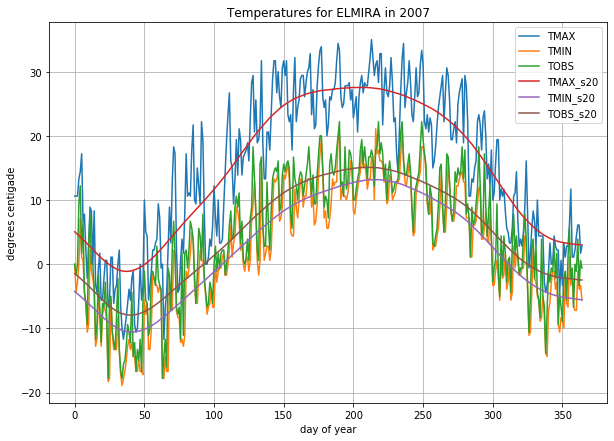

In [44]:
_tmax_20=unpackArray(pandas_df.loc['TMAX_s20','Values'],np.float16)/10.
_tmin_20=unpackArray(pandas_df.loc['TMIN_s20','Values'],np.float16)/10.
_tobs_20=unpackArray(pandas_df.loc['TOBS_s20','Values'],np.float16)/10.
_tmax=unpackArray(pandas_df.loc['TMAX','Values'],np.float16)/10.
_tmin=unpackArray(pandas_df.loc['TMIN','Values'],np.float16)/10.
_tobs=unpackArray(pandas_df.loc['TOBS','Values'],np.float16)/10.
figure(figsize=_figsize)
plot(_tmax,label='TMAX');
plot(_tmin,label='TMIN');
plot(_tobs,label='TOBS');

plot(_tmax_20,label='TMAX_s20');
plot(_tmin_20,label='TMIN_s20');
plot(_tobs_20,label='TOBS_s20');
xlabel('day of year')
ylabel('degrees centigade')
title('Temperatures for %s in %d'%(stat,year))
legend()
grid()

### Plot yearly plots

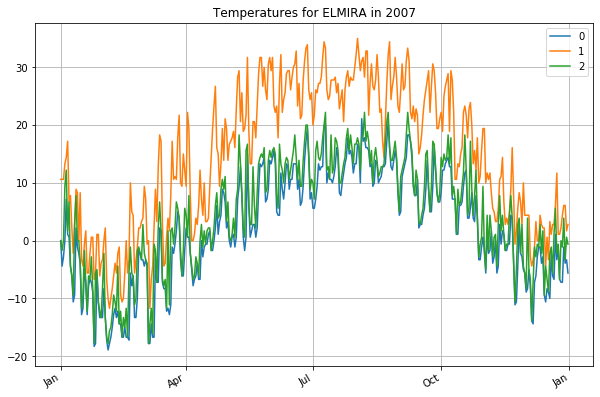

In [45]:
from lib.YearPlotter import YearPlotter
T=np.stack([_tmin,_tmax,_tobs])

fig, ax = plt.subplots(figsize=_figsize);
YP=YearPlotter()
YP.plot(T.transpose(),fig,ax,title='Temperatures for %s in %d'%(stat,year));
plt.savefig('percipitation.png')
#title('A sample of graphs');

#### Distribution of missing observations

The distribution of missing observations is not uniform throughout the year. This is visualised below.

In [46]:
from lib.MultiPlot import *
YP = YearPlotter()
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m,label=m)

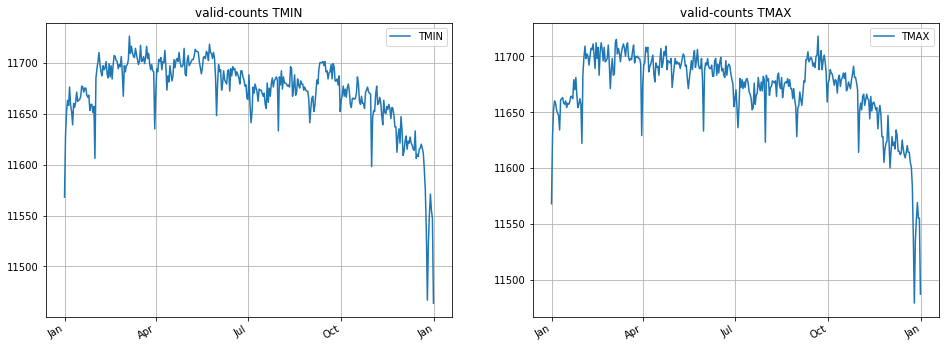

In [47]:
plot_pair(['TMIN','TMAX'],plot_valid)

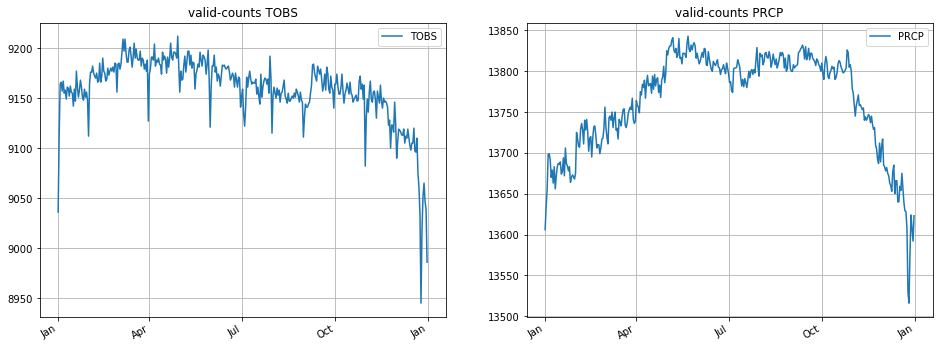

In [48]:
plot_pair(['TOBS','PRCP'],plot_valid)

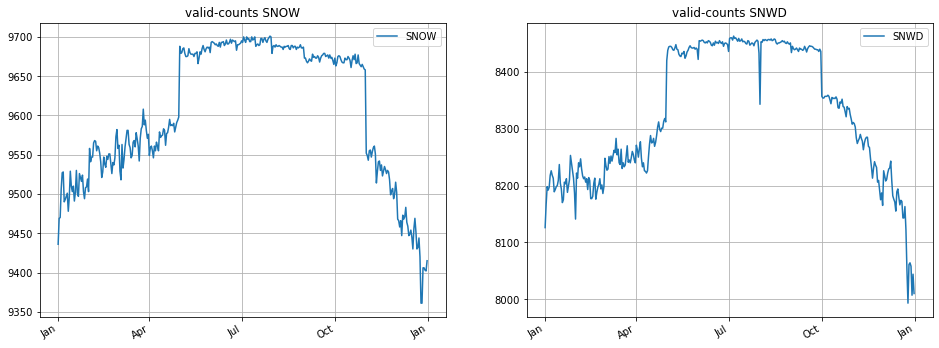

In [49]:
#for "SNOW" there are more missing measurements in the summer
#but for SNWD there are less missing in the summer
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [50]:
def plot_mean_std(m,fig,axis):
    scale=1.
    temps=['TMIN','TMAX','TOBS','TMIN_s20','TMAX_s20','TOBS_s20']
    percipitation=['PRCP','SNOW','SNWD','PRCP_s20','SNOW_s20','SNWD_s20']
    _labels=['mean+std','mean','mean-std']
    if (m in temps or m=='PRCP'):
        scale=10.
    mean=STAT[m]['Mean']/scale
    std=np.sqrt(STAT[m]['Var'])/scale
    graphs=np.vstack([mean+std,mean,mean-std]).transpose()
    YP.plot(graphs,fig,axis,labels=_labels,title='Mean+-std   '+m)
    if (m in temps):
        axis.set_ylabel('Degrees Celsius')
    if (m in percipitation):
        axis.set_ylabel('millimeter')

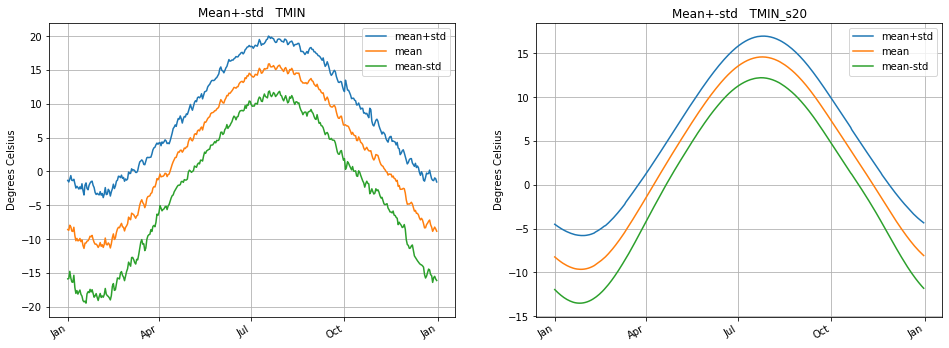

In [51]:
plot_pair(['TMIN','TMIN_s20'],plot_mean_std)

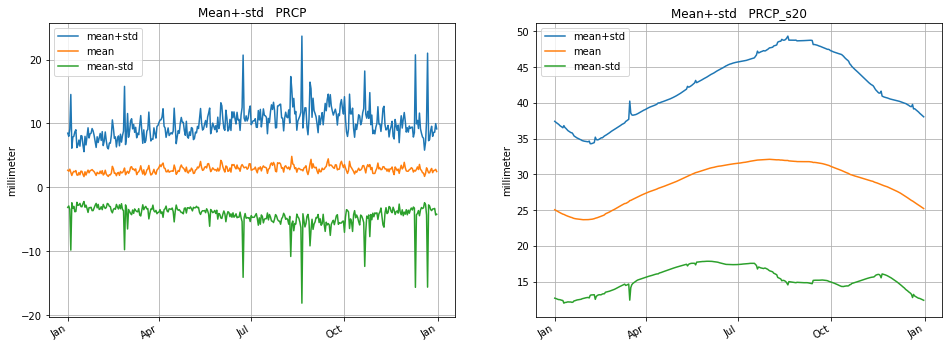

In [52]:
plot_pair(['PRCP','PRCP_s20'],plot_mean_std)

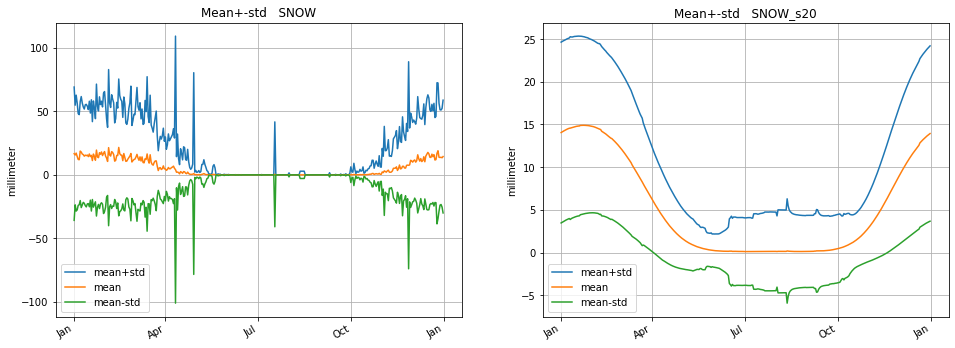

In [53]:
plot_pair(['SNOW', 'SNOW_s20'],plot_mean_std)

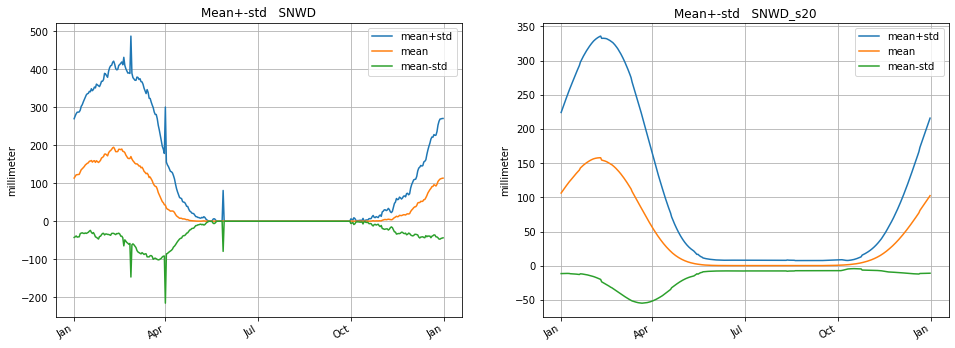

In [54]:
plot_pair(['SNWD', 'SNWD_s20'],plot_mean_std)

### Plotting percentage of variance explained by Eigen-vectors

In [55]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    L=([0,]+list(cumsum(EV[:k])))/sum(EV)
    plot(L)
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()

In [56]:
#create subdirectory to place plots
%mkdir -p r_figures

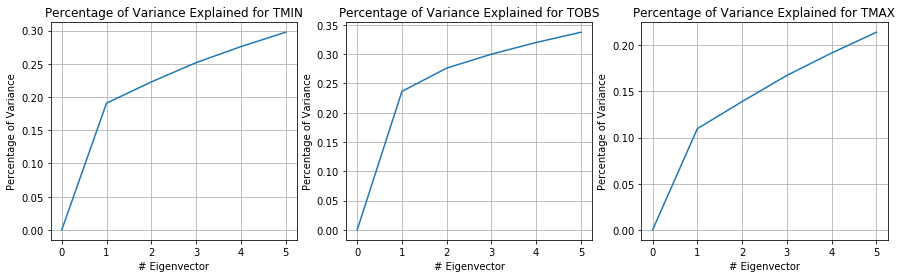

In [57]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

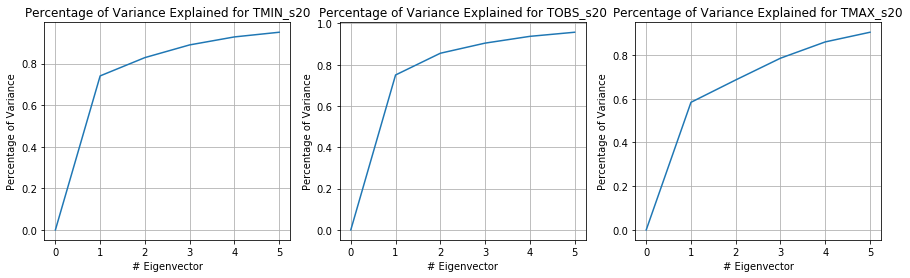

In [58]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN_s20', 'TOBS_s20', 'TMAX_s20']: 
    pltVarExplained(j)
    j+=1

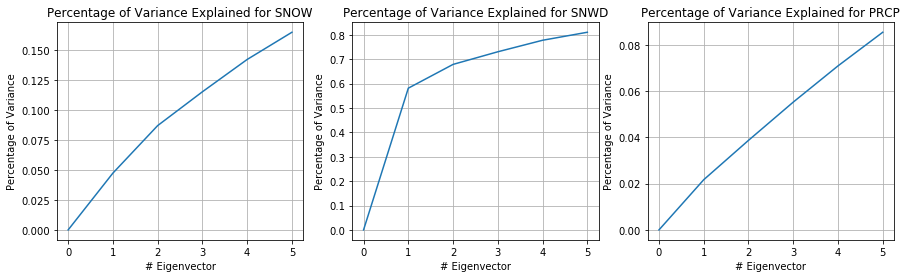

In [59]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

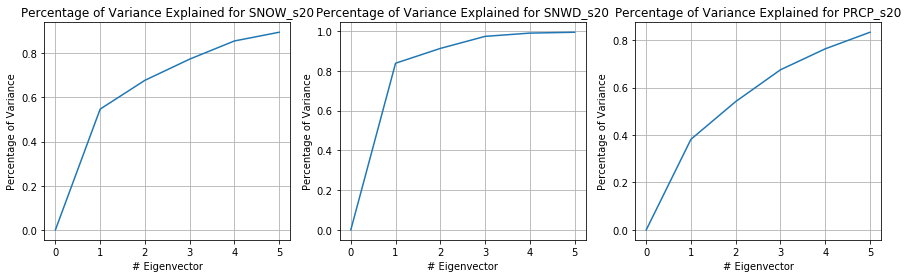

In [60]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW_s20', 'SNWD_s20', 'PRCP_s20']:
    pltVarExplained(j)
    j+=1 

### Plotting top 3 eigenvectors

In [61]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

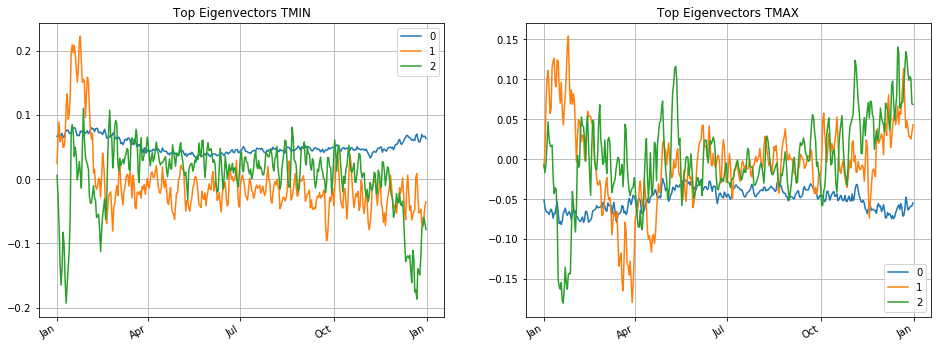

In [62]:
plot_pair(['TMIN','TMAX'],plot_eigen)

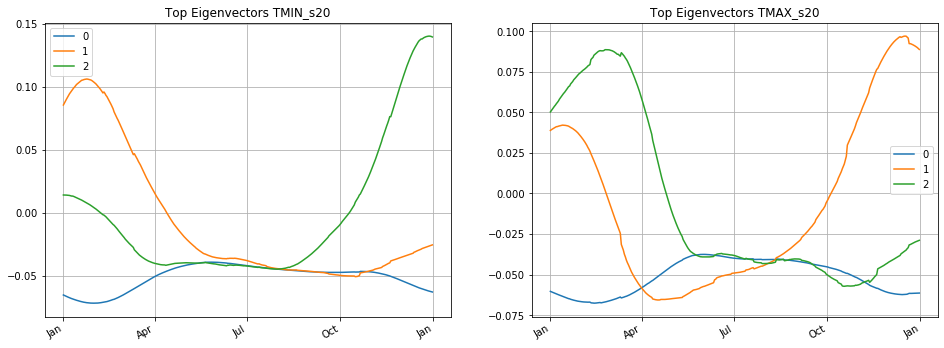

In [63]:
plot_pair(['TMIN_s20','TMAX_s20'],plot_eigen)

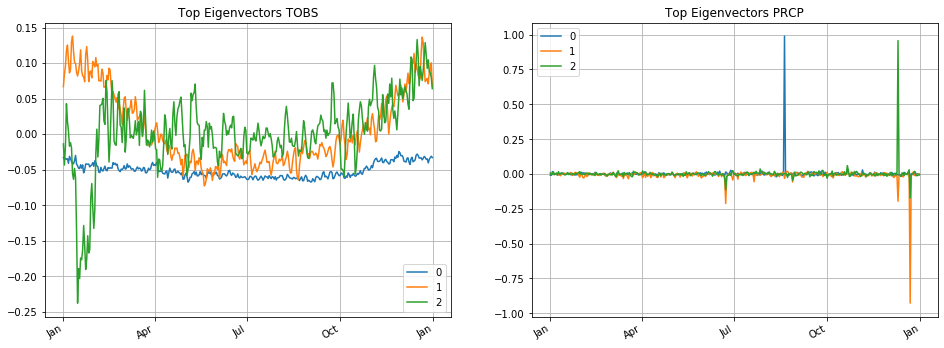

In [64]:
plot_pair(['TOBS','PRCP'],plot_eigen)

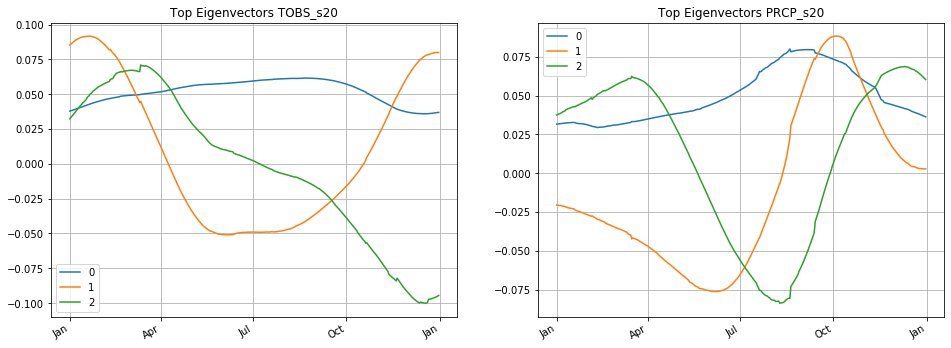

In [65]:
plot_pair(['TOBS_s20','PRCP_s20'],plot_eigen)

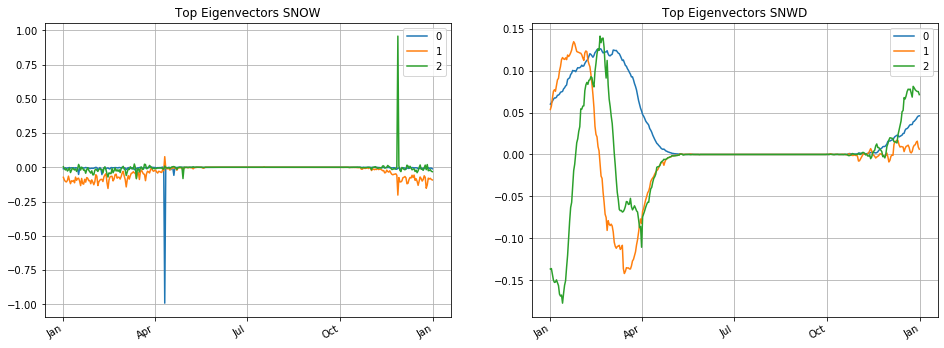

In [66]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

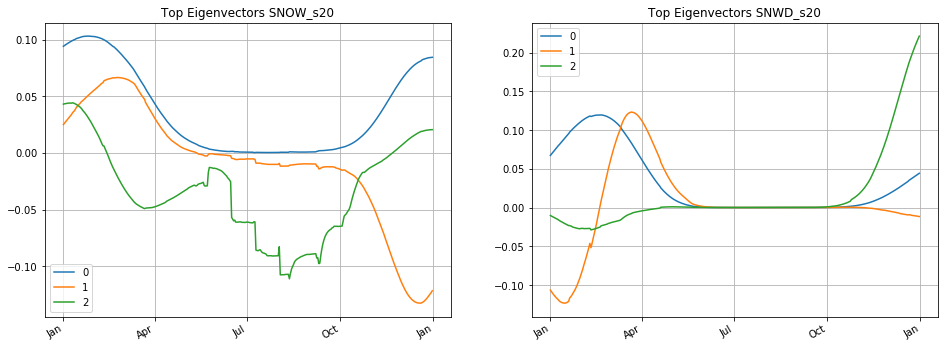

In [67]:
plot_pair(['SNOW_s20', 'SNWD_s20'],plot_eigen)

## Weather Data : Visualisation After Smoothing
For New York State


In [68]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStatistics.py'])

from pyspark import SparkContext
from pyspark.sql import *
import pyspark.sql
sqlContext = SQLContext(sc)

import numpy as np
from lib.numpy_pack import packArray,unpackArray
from lib.spark_PCA import computeCov
from lib.computeStatistics import *

Populating the interactive namespace from numpy and matplotlib


In [69]:
import warnings 
warnings.filterwarnings('ignore')

_figsize=(10,7)

### Read Data
Read Raw data for state

In [70]:
!rm -r ../Data/Weather/NY.*
!ls ../Data/Weather

rm: ../Data/Weather/NY.*: No such file or directory
ls: ../Data/Weather: No such file or directory


In [71]:
state='NY'
data_dir='Data/Weather'

tarname=state+'.tgz'
parquet=state+'.parquet'

!rm -rf $data_dir/$tarname

command="curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/%s > %s/%s"%(tarname,data_dir,tarname)
print(command)
!$command
!ls -lh $data_dir/$tarname

curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/NY.tgz > Data/Weather/NY.tgz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63.2M  100 63.2M    0     0  3083k      0  0:00:20  0:00:20 --:--:-- 3044k
-rw-r--r--  1 charlottefettes  staff    63M 19 Feb 14:49 Data/Weather/NY.tgz


In [72]:
!ls -l $data_dir

total 233728
drwxr-xr-x  2374 charlottefettes  staff     75968 19 Feb 14:43 Joined_smoothed_PRCP.parquet
drwxr-xr-x    31 charlottefettes  staff       992 19 Feb 14:48 NY.parquet
-rw-r--r--     1 charlottefettes  staff  66288146 19 Feb 14:49 NY.tgz
-rw-r--r--     1 charlottefettes  staff  51365103 19 Feb 14:48 STAT_NY.pickle
-rw-r--r--@    1 charlottefettes  staff    731305 18 Feb 18:13 US_stations.tsv
-rw-r--r--     1 charlottefettes  staff    353056 19 Feb 14:48 Weather_Stations.tgz
drwxr-xr-x     8 charlottefettes  staff       256 19 Feb 14:42 decon_NY_PRCP_s20.parquet
drwxr-xr-x    10 charlottefettes  staff       320 19 Feb 14:42 decon_NY_SNWD.parquet
drwxr-xr-x    10 charlottefettes  staff       320 19 Feb 14:42 recon_NY_SNWD.parquet
drwxr-xr-x     9 charlottefettes  staff       288 19 Feb 14:48 stations.parquet


In [73]:
cur_dir,=!pwd
%cd $data_dir
!tar -xzf $tarname
!du -h ./$parquet
%cd $cur_dir

/Users/charlottefettes/Documents/Data_Science_Projects/Spark_Data_Analysis/Data/Weather
 76M	./NY.parquet
/Users/charlottefettes/Documents/Data_Science_Projects/Spark_Data_Analysis


In [74]:
!du -h $data_dir/$parquet

 76M	Data/Weather/NY.parquet


In [75]:
print(parquet)
weather_df=sqlContext.read.parquet(data_dir+'/'+parquet)
#weather_df=weather_df.drop('State') # we drop State because it already exists in "Stations".
print('number of rows=',weather_df.count())

NY.parquet
number of rows= 168398


In [76]:
weather_df.show(1)

+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
|    Station|Measurement|Year|              Values|       dist_coast|      latitude|         longitude|        elevation|state|             name|
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
|USW00094704|   PRCP_s20|1945|[00 00 00 00 00 0...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
only showing top 1 row



### Read statistics information for state

In [77]:
#read statistics
filename='STAT_%s.pickle'%state
command="curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/%s.gz > %s/%s.gz"%(filename,data_dir,filename)
print(command)
!$command

curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/STAT_NY.pickle.gz > Data/Weather/STAT_NY.pickle.gz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29.9M  100 29.9M    0     0  1702k      0  0:00:17  0:00:17 --:--:-- 3297k  0:01:20  0:00:02  0:01:18  382k


In [78]:
gzpath='%s/%s.gz'%(data_dir,filename)
print(gzpath)
!ls -l $gzpath

Data/Weather/STAT_NY.pickle.gz
-rw-r--r--  1 charlottefettes  staff  31373293 19 Feb 14:49 Data/Weather/STAT_NY.pickle.gz


In [79]:
print(gzpath)
!gunzip -f $gzpath
!ls -l $data_dir

Data/Weather/STAT_NY.pickle.gz
total 233728
drwxr-xr-x  2374 charlottefettes  staff     75968 19 Feb 14:43 Joined_smoothed_PRCP.parquet
drwxr-xr-x    31 charlottefettes  staff       992 19 Feb 14:49 NY.parquet
-rw-r--r--     1 charlottefettes  staff  66288146 19 Feb 14:49 NY.tgz
-rw-r--r--     1 charlottefettes  staff  51365103 19 Feb 14:49 STAT_NY.pickle
-rw-r--r--@    1 charlottefettes  staff    731305 18 Feb 18:13 US_stations.tsv
-rw-r--r--     1 charlottefettes  staff    353056 19 Feb 14:48 Weather_Stations.tgz
drwxr-xr-x     8 charlottefettes  staff       256 19 Feb 14:42 decon_NY_PRCP_s20.parquet
drwxr-xr-x    10 charlottefettes  staff       320 19 Feb 14:42 decon_NY_SNWD.parquet
drwxr-xr-x    10 charlottefettes  staff       320 19 Feb 14:42 recon_NY_SNWD.parquet
drwxr-xr-x     9 charlottefettes  staff       288 19 Feb 14:48 stations.parquet


In [80]:
STAT,STAT_Descriptions = load(open(data_dir+'/'+filename,'rb'), allow_pickle=True)

In [81]:
Measurements = STAT.keys()
Measurements

dict_keys(['SNOW_s20', 'TMIN_s20', 'TOBS', 'SNWD_s20', 'PRCP_s20', 'TOBS_s20', 'PRCP', 'TMAX', 'TMAX_s20', 'TMIN', 'SNOW', 'SNWD'])

In [82]:
print("   Name  \t                 Description             \t  Size")
print("-"*80)
print('\n'.join(["%10s\t%40s\t%s"%(s[0],s[1],str(s[2])) for s in STAT_Descriptions]))

   Name  	                 Description             	  Size
--------------------------------------------------------------------------------
SortedVals	                        Sample of values	vector whose length varies between measurements
     UnDef	      sample of number of undefs per row	vector whose length varies between measurements
      mean	                              mean value	()
       std	                                     std	()
    low100	                               bottom 1%	()
   high100	                                  top 1%	()
   low1000	                             bottom 0.1%	()
  high1000	                                top 0.1%	()
         E	                   Sum of values per day	(365,)
        NE	                 count of values per day	(365,)
      Mean	                                    E/NE	(365,)
         O	                   Sum of outer products	(365, 365)
        NO	               counts for outer products	(365, 365)
       Cov	                

### Read information about US weather stations

In [83]:
filename='Weather_Stations.tgz'
parquet='stations.parquet'
command="curl https://mas-dse-open.s3.amazonaws.com/Weather/%s > %s/%s"%(filename,data_dir,filename)
print(command)
!$command

curl https://mas-dse-open.s3.amazonaws.com/Weather/Weather_Stations.tgz > Data/Weather/Weather_Stations.tgz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  344k  100  344k    0     0   241k      0  0:00:01  0:00:01 --:--:--  241k


In [84]:
%cd $data_dir
!tar -xzf $filename
!du -s *.parquet
%cd $cur_dir

/Users/charlottefettes/Documents/Data_Science_Projects/Spark_Data_Analysis/Data/Weather
210152	Joined_smoothed_PRCP.parquet
155648	NY.parquet
26200	decon_NY_PRCP_s20.parquet
3840	decon_NY_SNWD.parquet
3840	recon_NY_SNWD.parquet
832	stations.parquet
/Users/charlottefettes/Documents/Data_Science_Projects/Spark_Data_Analysis


In [85]:
stations_df =sqlContext.read.parquet(data_dir+'/'+parquet)
stations_df.show(5)

+-----------+----------+--------+---------+---------+-----+----------------+
|    Station|Dist_coast|Latitude|Longitude|Elevation|State|            Name|
+-----------+----------+--------+---------+---------+-----+----------------+
|USC00341900|   739.956|    36.3| -96.4667|    242.3|   OK|       CLEVELAND|
|USC00428114|    908.22|    40.1|-111.6667|   1409.1|   UT|SPANISH FORK 1 S|
|USC00165926|   23.8801| 29.7853| -90.1158|      0.9|   LA|   MARRERO 9 SSW|
|USC00411974|   541.905| 31.5333|-101.2842|    755.9|   TX|        COPE RCH|
|USC00318906|   310.311| 35.5231| -81.4439|    274.3|   NC|    VALE AG 2 SW|
+-----------+----------+--------+---------+---------+-----+----------------+
only showing top 5 rows



In [86]:
weather_df.join?

In [87]:
jdf=weather_df.drop('name','latitude','longitude','elevation','dist_coast','state').join(stations_df,on='Station',how='left')
jdf.show(3)

+-----------+-----------+----+--------------------+----------+--------+---------+---------+-----+-----------------+
|    Station|Measurement|Year|              Values|Dist_coast|Latitude|Longitude|Elevation|State|             Name|
+-----------+-----------+----+--------------------+----------+--------+---------+---------+-----+-----------------+
|USW00094704|   PRCP_s20|1945|[00 00 00 00 00 0...|   361.832| 42.5708| -77.7133|    208.8|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1946|[99 46 52 46 0B 4...|   361.832| 42.5708| -77.7133|    208.8|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1947|[79 4C 75 4C 8F 4...|   361.832| 42.5708| -77.7133|    208.8|   NY|DANSVILLE MUNI AP|
+-----------+-----------+----+--------------------+----------+--------+---------+---------+-----+-----------------+
only showing top 3 rows



In [88]:
sqlContext.registerDataFrameAsTable(jdf,'jdf')

#find stations in NY with the most measurements
sqlContext.sql('select Name,count(Name) as count from jdf GROUP BY Name ORDER BY count DESC').show(5)

+--------------------+-----+
|                Name|count|
+--------------------+-----+
|     SETAUKET STRONG| 1438|
|NEW YORK CNTRL PK...| 1430|
|            LOWVILLE| 1410|
|              ELMIRA| 1408|
|            ANGELICA| 1406|
+--------------------+-----+
only showing top 5 rows



In [89]:
#find how many measurements of each type for a particlar station
stat='ELMIRA'
Query="""
SELECT Measurement,count(Measurement) as count 
FROM jdf 
WHERE Name='%s' 
GROUP BY Measurement
"""%stat
sqlContext.sql(Query).show()

+-----------+-----+
|Measurement|count|
+-----------+-----+
|   TMIN_s20|  120|
|       TMIN|  120|
|   SNOW_s20|  121|
|       TOBS|  113|
|   SNWD_s20|  109|
|   TOBS_s20|  113|
|   PRCP_s20|  121|
|       TMAX|  120|
|       SNOW|  121|
|   TMAX_s20|  120|
|       SNWD|  109|
|       PRCP|  121|
+-----------+-----+



In [90]:
#find year with all 6 measurements
Query="""
SELECT Year,count(Year) as count 
FROM jdf 
WHERE Name='%s' 
GROUP BY Year
ORDER BY count DESC
"""%stat
sqlContext.sql(Query).show(5)

+----+-----+
|Year|count|
+----+-----+
|1950|   12|
|1951|   12|
|1919|   12|
|1936|   12|
|1921|   12|
+----+-----+
only showing top 5 rows



In [91]:
#get all measurements for a particular year and a particular station
year=2007
Query="""
SELECT *
FROM jdf 
WHERE Name='%s' 
and Year=%d
"""%(stat,year )
pandas_df=sqlContext.sql(Query).toPandas()
pandas_df=pandas_df.set_index('Measurement')
pandas_df

Station  Year  \
Measurement                      
SNOW_s20     USC00302610  2007   
SNWD_s20     USC00302610  2007   
TOBS_s20     USC00302610  2007   
PRCP_s20     USC00302610  2007   
TMAX_s20     USC00302610  2007   
TMIN_s20     USC00302610  2007   
PRCP         USC00302610  2007   
SNOW         USC00302610  2007   
SNWD         USC00302610  2007   
TMAX         USC00302610  2007   
TMIN         USC00302610  2007   
TOBS         USC00302610  2007   

                                                        Values  Dist_coast  \
Measurement                                                                  
SNOW_s20     [102, 61, 227, 61, 128, 62, 17, 63, 170, 63, 7...  272.682007   
SNWD_s20     [170, 70, 121, 71, 48, 72, 170, 72, 45, 73, 19...  272.682007   
TOBS_s20     [85, 203, 22, 204, 135, 204, 255, 204, 123, 20...  272.682007   
PRCP_s20     [25, 76, 17, 76, 25, 76, 30, 76, 36, 76, 43, 7...  272.682007   
TMAX_s20     [79, 82, 17, 82, 214, 81, 149, 81, 83, 81, 15,...  272.682007   
TMIN_s20     [85, 209, 139, 209, 195, 209, 253, 209, 59, 21...  272.682007   
PRCP         [0, 69, 0, 0, 0, 0, 0, 72, 128, 86, 0, 66, 112...  272.682007   
SNOW         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  272.682007   
SNWD         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  272.682007   
TMAX         [160, 86, 160, 86, 160, 86, 40, 88, 128, 88, 9...  272.682007   
TMIN         [0, 0, 128, 209, 0, 207, 0, 0, 128, 84, 128, 7...  272.682007   
TOBS         [0, 0, 64, 204, 0, 0, 224, 85, 160, 87, 64, 76...  272.682007   

              Latitude  Longitude   Elevation State    Name  
Measurement                                                  
SNOW_s20     42.099701   -76.8358  288.600006    NY  ELMIRA  
SNWD_s20     42.099701   -76.8358  288.600006    NY  ELMIRA  
TOBS_s20     42.099701   -76.8358  288.600006    NY  ELMIRA  
PRCP_s20     42.099701   -76.8358  288.600006    NY  ELMIRA  
TMAX_s20     42.099701   -76.8358  288.600006    NY  ELMIRA  
TMIN_s20     42.099701   -76.8358  288.600006    NY  ELMIRA  
PRCP         42.099701   -76.8358  288.600006    NY  ELMIRA  
SNOW         42.099701   -76.8358  288.600006    NY  ELMIRA  
SNWD         42.099701   -76.8358  288.600006    NY  ELMIRA  
TMAX         42.099701   -76.8358  288.600006    NY  ELMIRA  
TMIN         42.099701   -76.8358  288.600006    NY  ELMIRA  
TOBS         42.099701   -76.8358  288.600006    NY  ELMIRA

## Plots

In [92]:
raw_measurements=[m for m in Measurements if not '_s20' in m]
raw_measurements

['TOBS', 'PRCP', 'TMAX', 'TMIN', 'SNOW', 'SNWD']

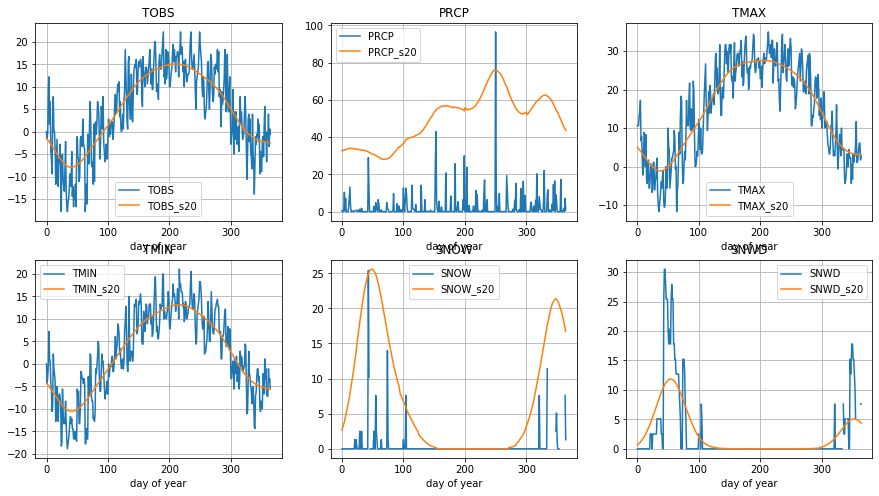

In [93]:
figure(figsize=[15,8])
i=1
for m in raw_measurements:
    subplot(2,3,i)
    i+=1
    if m=='PRCP' or m=='SNOW':
        f=20
    else:
        f=1
    plot(unpackArray(pandas_df.loc[m,'Values'],np.float16)/10.,label=m);
    ms=m+"_s20"
    
    plot(f*unpackArray(pandas_df.loc[ms,'Values'],np.float16)/10.,label=ms);
    xlabel('day of year')
    title(m)
    legend()
    grid()

In [94]:
from lib.YearPlotter import *
from lib.MultiPlot import *
YP=YearPlotter()
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m,label=m)

### Plots of mean and std of observations

In [95]:
def plot_mean_std(m,fig,axis):
    scale=1.
    temps=['TMIN','TMAX','TOBS']
    percipitation=['PRCP','SNOW','SNWD']
    _labels=['mean+std','mean','mean-std']
    if (m in temps or m=='PRCP'):
        scale=10.
    mean=STAT[m]['Mean']/scale
    std=np.sqrt(STAT[m]['Var'])/scale
    graphs=np.vstack([mean+std,mean,mean-std]).transpose()
    YP.plot(graphs,fig,axis,labels=_labels,title='Mean+-std   '+m)
    if (m in temps):
        axis.set_ylabel('Degrees Celsius')
    if (m in percipitation):
        axis.set_ylabel('millimeter')

In [96]:
from lib.MultiPlot import *

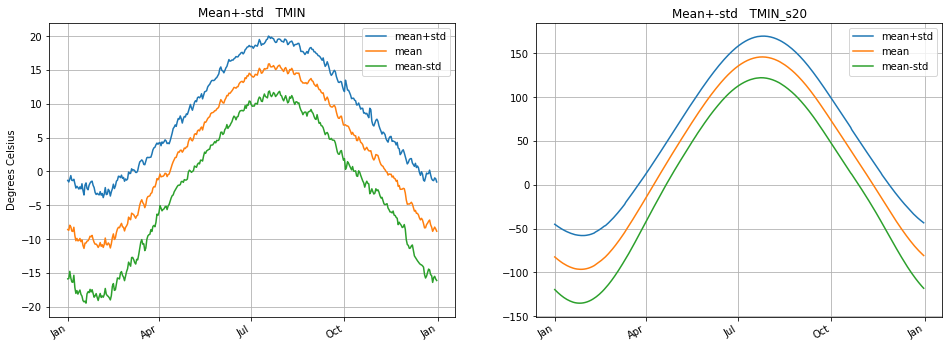

In [97]:
plot_pair(['TMIN','TMIN_s20'],plot_mean_std)

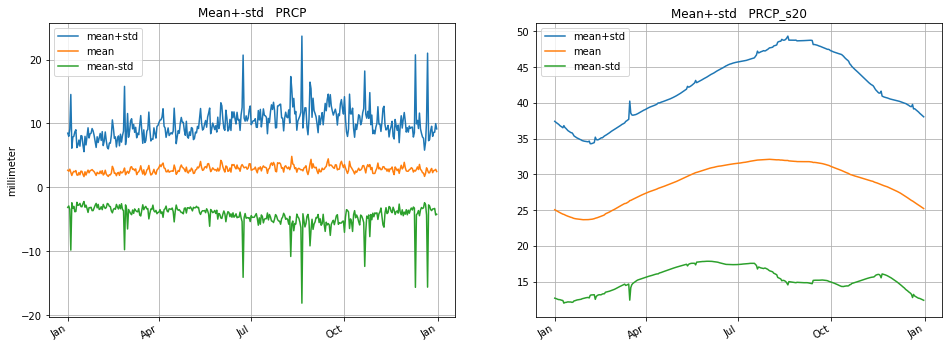

In [98]:
plot_pair(['PRCP','PRCP_s20'],plot_mean_std)

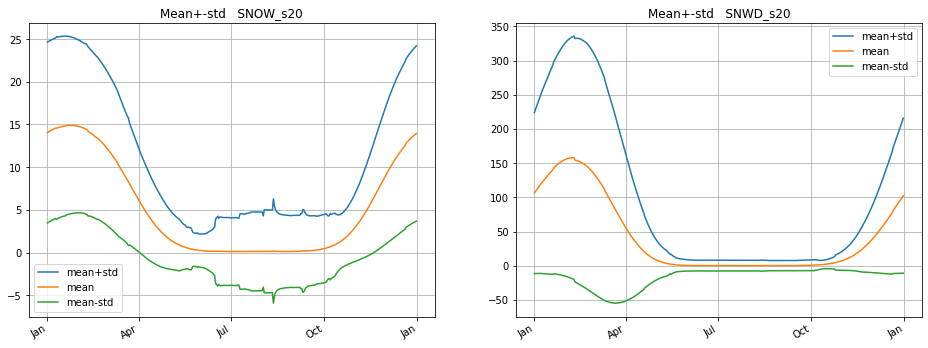

In [99]:
plot_pair(['SNOW_s20', 'SNWD_s20'],plot_mean_std)

### Plotting percentage of variance explained by Eigen-vectors

In [100]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    L=([0,]+list(cumsum(EV[:k])))/sum(EV)
    #print m,L
    plot(L)
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()

In [101]:
# create a subdirectory in which to place the plots.
!mkdir r_figures

mkdir: r_figures: File exists


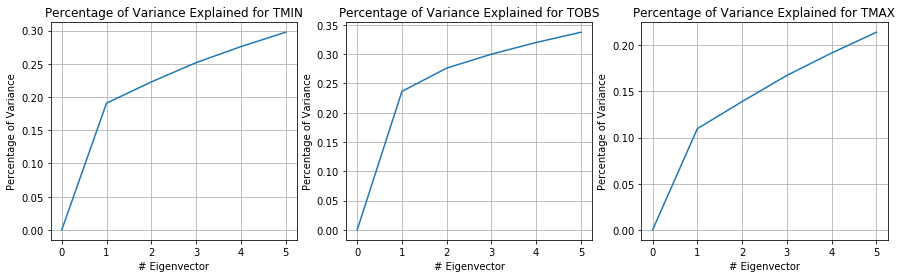

In [102]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1
f.savefig('r_figures/VarExplained1.png')

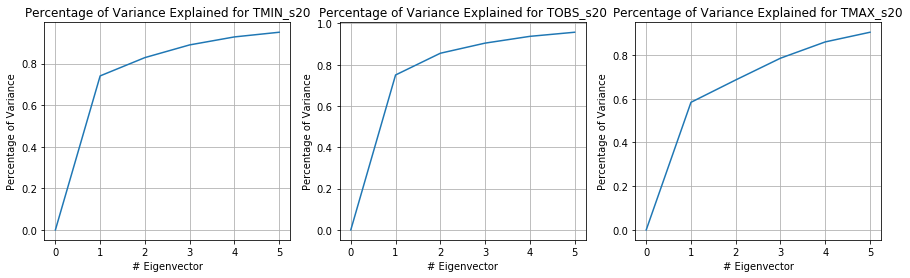

In [103]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN_s20', 'TOBS_s20', 'TMAX_s20']: #,
    pltVarExplained(j)
    j+=1
f.savefig('r_figures/VarExplained1.png')

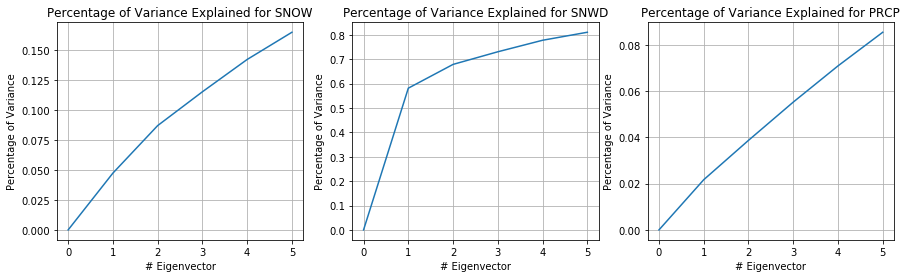

In [104]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 
f.savefig('r_figures/VarExplained2.png')

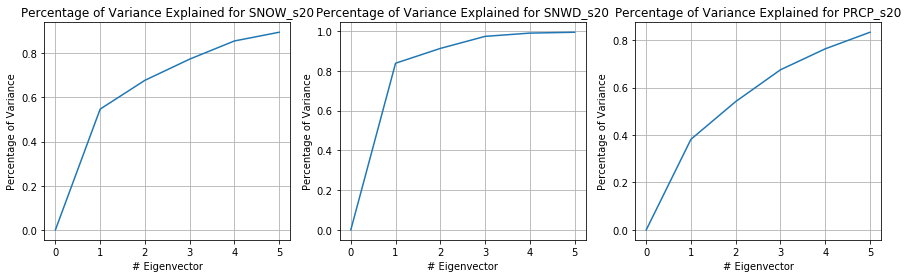

In [105]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW_s20', 'SNWD_s20', 'PRCP_s20']:
    pltVarExplained(j)
    j+=1 
f.savefig('r_figures/VarExplained2.png') 

### Plotting top 3 eigenvectors

In [106]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

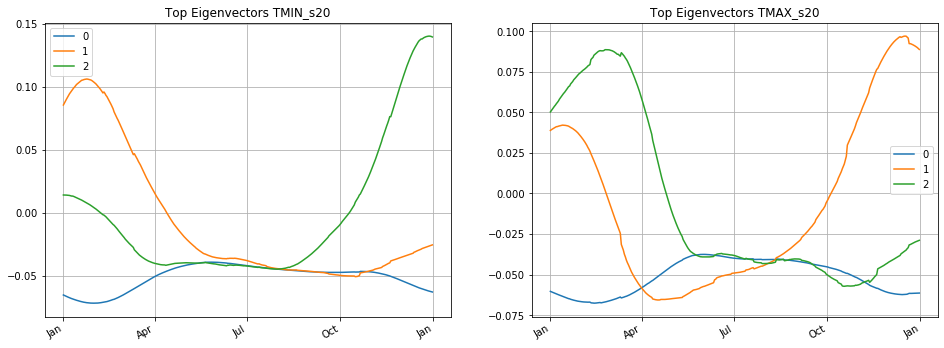

In [107]:
plot_pair(['TMIN_s20','TMAX_s20'],plot_eigen)

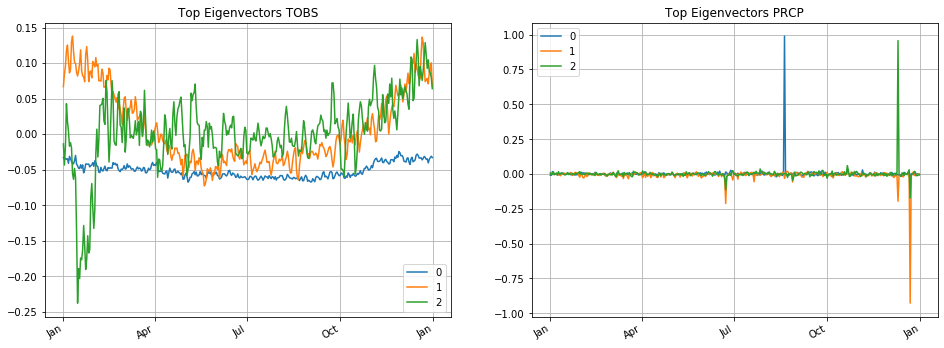

In [108]:
plot_pair(['TOBS','PRCP'],plot_eigen)

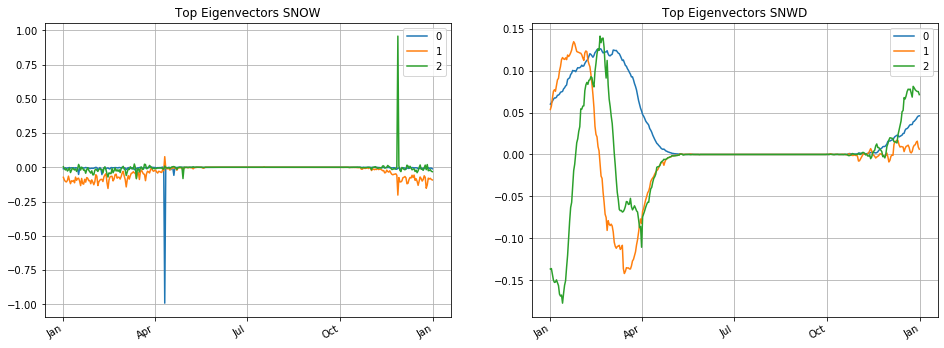

In [109]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

## Spectral Analysis of Snow Depth in NY state

In [110]:
#setup
data_dir='Data/Weather'
#!ls $data_dir
state='NY'
m='SNWD'

In [113]:
# Enable automiatic reload of libraries
%load_ext autoreload
%autoreload 2 # means that all modules are reloaded before every command

%pylab inline
#%pylab inline
import numpy as np

import findspark
findspark.init()

#import sys
#sys.path.append('./lib')

from lib.numpy_pack import packArray,unpackArray

#from lib.Eigen_decomp import Eigen_decomp
from lib.YearPlotter import YearPlotter
from lib.decomposer import *
from lib.Reconstruction_plots import *


from lib.import_modules import import_modules,modules
import_modules(modules)

import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual,widgets
import ipywidgets as widgets

print('version of ipwidgets=',widgets.__version__)

import warnings  # Suppress Warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=1.0.0 	required version>=0.19.2

     numpy as    np 	version=1.18.1 	required version>=1.12.0

   sklearn as    sk 	version=0.22.1 	required version>=0.18.1

module urllib has no version
   pyspark as pyspark 	version=2.4.5 	required version>=2.1.0

ipywidgets as ipywidgets 	version=7.5.1 	required version>=6.0.0

version of ipwidgets= 7.5.1


In [114]:
from pyspark import SparkContext
sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStatistics.py','lib/Reconstruction_plots.py','lib/decomposer.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

### Read Statistics File

In [115]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%state
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print('keys from STAT=',measurements)

keys from STAT= dict_keys(['SNOW_s20', 'TMIN_s20', 'TOBS', 'SNWD_s20', 'PRCP_s20', 'TOBS_s20', 'PRCP', 'TMAX', 'TMAX_s20', 'TMIN', 'SNOW', 'SNWD'])


In [116]:
EigVec=STAT[m]['eigvec']
Mean=STAT[m]['Mean']

### Read data file into a spark DataFrame
Here, the focus is on the snow-depth records, because the eigen-vectors for them make sense.

In [117]:
#read data
filename=data_dir+'/%s.parquet'%state
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.Measurement==m)
df=df.drop('State')
df.show(5)

+-----------+-----------+----+--------------------+------------------+--------+------------------+-----------------+--------+
|    Station|Measurement|Year|              Values|        dist_coast|latitude|         longitude|        elevation|    name|
+-----------+-----------+----+--------------------+------------------+--------+------------------+-----------------+--------+
|USC00308600|       SNWD|1932|[00 7E 00 7E 00 7...|171.58099365234375|   42.75|-73.68329620361328|7.300000190734863|TROY L&D|
|USC00308600|       SNWD|1956|[00 7E 00 7E 00 7...|171.58099365234375|   42.75|-73.68329620361328|7.300000190734863|TROY L&D|
|USC00308600|       SNWD|1957|[C0 54 C0 54 C0 5...|171.58099365234375|   42.75|-73.68329620361328|7.300000190734863|TROY L&D|
|USC00308600|       SNWD|1958|[00 00 00 00 00 0...|171.58099365234375|   42.75|-73.68329620361328|7.300000190734863|TROY L&D|
|USC00308600|       SNWD|1959|[00 00 40 4E 40 4...|171.58099365234375|   42.75|-73.68329620361328|7.300000190734863|TR

## Computing decomposition for each row, and add columns for coefficients and residuals

Residuals are the remainder left after successive approximations:  
1) Original vector = $\vec{v}$

2) $\vec{r}_0=\vec{v}-\vec{\mu}$

3) $\vec{r}_1=\vec{r}_0-(\vec{v}\cdot \vec{u}_1) \vec{u}_1$

4) $\vec{r}_2=\vec{r}_1-(\vec{v}\cdot \vec{u}_2) \vec{u}_2$

5) $\vec{r}_3=\vec{r}_0-(\vec{v}\cdot \vec{u}_3) \vec{u}_3$  
6) ......

For each residual $\vec{r}_i$ it's square norm is computed, which is referred to as the **residual norm** :
$$\|\vec{r}_i\|_2^2 = \sum_{j=1}^n (r_{i,j})^2$$  
The smaller the norm, the better the approximation.

#### From linear algebra:

1) The zero'th residual norm is the square distance of $\vec{v}$ from the mean $\vec{\mu}$

2) The $k$'th residual norm is the minimal square between $\vec{v}$ and a point that can be exspressed as
$$ \vec{w}_k = \vec{\mu} + \sum_{i=1}^k c_i \vec{u}_i$$
Where $c_1,\ldots,c_k$ are arbitrary real numbers; $\vec{w}_k$ is the $k$'th approximation or reconstruction of $\vec{v}$.

3) The residual norms are non-increasing.  
4) The residual vector $\vec{r}_n$ is the zero vector. In other words, $\vec{w}_n = \vec{v}$.

`decompose_dataframe` extracts the series from the row, computes the `k` to decomposition coefficients and the square norm of the residuals and constructs a new row that is reassembled into a new dataframe.  

For more details, use `%load lib/decomposer.py`

In [118]:
%%time
k=5
df2=decompose_dataframe(sqlContext,df,EigVec[:,:k],Mean).cache() #make it possible to generate only first k coefficients

CPU times: user 20.1 ms, sys: 2.42 ms, total: 22.5 ms
Wall time: 502 ms


In [119]:
%%time
print(df2.count())

14617
CPU times: user 1.39 ms, sys: 1.03 ms, total: 2.42 ms
Wall time: 1.81 s


### Join decomposition information with station information

In [120]:
!ls $data_dir

Joined_smoothed_PRCP.parquet Weather_Stations.tgz
NY.parquet                   decon_NY_PRCP_s20.parquet
NY.tgz                       decon_NY_SNWD.parquet
STAT_NY.pickle               recon_NY_SNWD.parquet
US_stations.tsv              stations.parquet


In [121]:
stations_df=sqlContext.read.parquet(data_dir+'/stations.parquet').drop('Dist_coast').drop('Elevation').drop('Latitude').drop('Longitude').drop('Name')

In [122]:
stations_df.show(4)

+-----------+-----+
|    Station|State|
+-----------+-----+
|USC00341900|   OK|
|USC00428114|   UT|
|USC00165926|   LA|
|USC00411974|   TX|
+-----------+-----+
only showing top 4 rows



In [123]:
jdf=df2.join(stations_df,on='Station',how='left')
jdf.show(1)

+-----------+-----------+--------------------+----+------------------+------------------+------------------+-----------------+-------------------+------------------+-----------------+--------+------------------+--------+----------------+------------------+------------------+------------------+------------------+--------+---------+-----+
|    Station|Measurement|              Values|Year|           coeff_1|           coeff_2|           coeff_3|          coeff_4|            coeff_5|        dist_coast|        elevation|latitude|         longitude|    name|           res_1|             res_2|             res_3|             res_4|             res_5|res_mean|total_var|State|
+-----------+-----------+--------------------+----+------------------+------------------+------------------+-----------------+-------------------+------------------+-----------------+--------+------------------+--------+----------------+------------------+------------------+------------------+------------------+--------+

### Removing years with little snow
In some locations in NY and in some year, there is almost no snow accumulation. These will be treated separately. To do the error of using the average is compared to the error of using a zero vector. Only those yearXstation is kept where the mean is a better approximation than the zero Vector

In [124]:
%%time
#filter out vectors for which the mean is a worse approximation than zero.
print('all Rows',jdf.count())
df3=jdf.filter(jdf.res_mean<1)
print('Rows where mean is better approx than zero',df3.count())

all Rows 14617
Rows where mean is better approx than zero 8174
CPU times: user 3.57 ms, sys: 1.81 ms, total: 5.38 ms
Wall time: 306 ms


### Saving the decomposition in a Parquet file

In [125]:
filename=data_dir+'/decon_'+state+'_'+m+'.parquet'
!rm -rf $filename
df3.write.parquet(filename)

!du -sh $data_dir/*.parquet

103M	Data/Weather/Joined_smoothed_PRCP.parquet
 76M	Data/Weather/NY.parquet
 13M	Data/Weather/decon_NY_PRCP_s20.parquet
1.9M	Data/Weather/decon_NY_SNWD.parquet
1.9M	Data/Weather/recon_NY_SNWD.parquet
416K	Data/Weather/stations.parquet


## Plot mean and top eigenvectors

Construct approximations of a time series using the mean and the $k$ top eigen-vectors.
First, the mean and the top $k$ eigenvectors are plotted

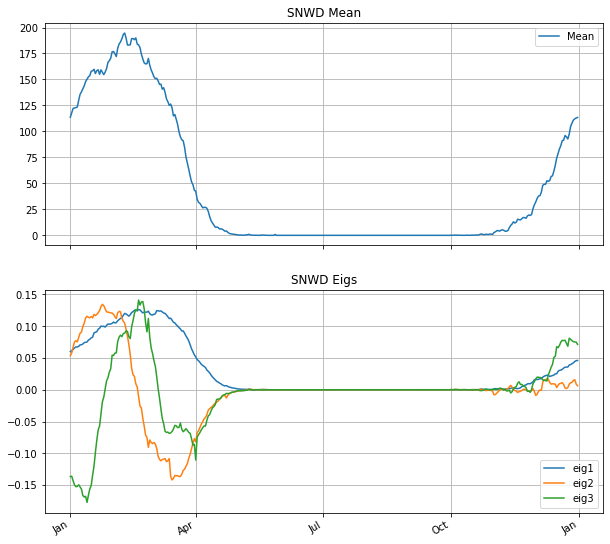

In [126]:
import pylab as plt
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,10));
k=3
EigVec=np.array(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])
fig.savefig('r_figures/SNWD_mean_eigs')

## Plot percentage of variance explained

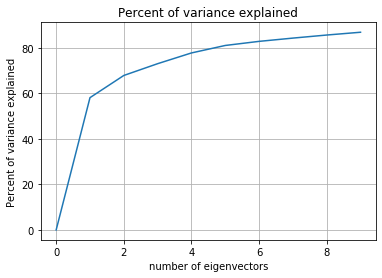

In [127]:
# x=0 in graphs below correspond to the fraction of variance explained by mean alone
# x=1,2,3,... are residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=np.cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

## Exploring the decomposition
### Intuitive analysis

In [128]:
#combine mean with Eigvecs and scale to similar range.
print(EigVec.shape)
_norm_Mean=Mean/max(Mean)*0.2
A=[_norm_Mean]+[EigVec[:,i] for i in range(EigVec.shape[1])]
Combined=np.stack(A).transpose()
Combined.shape

(365, 3)


(365, 4)

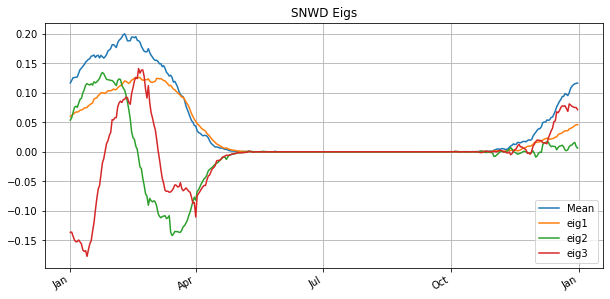

In [129]:
import pylab as plt
fig,axes=plt.subplots(1,1, sharex='col', sharey='row',figsize=(10,5));
k=3
EigVec=np.array(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
#YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(Combined,fig,axes,title=m+' Eigs',labels=['Mean']+['eig'+str(i+1) for i in range(k)])

* **Eig1** is very similar to the Mean --- Indicates heavy/light snow
* If **coef_1** is large: snow accumulation is higher.

* **Eig2** is positive january, negative march. Indicates early vs. late season
* If **coef_2** is high: snow season is early.

* **Eig3** is positive Feb, negative Jan, March -- Indicates a short or long season.
* If **Coef_3** is high: Season is short.

### Studying the effect of Coefficient 2

In [130]:
df4=df3.filter(df3.res_2<0.1).sort(df3.coeff_2)
print(df4.count())
all_rows=df4.collect()
rows=all_rows[:12]

216


In [131]:
#checking res_2 is smaller than 0.1 and rows are sorted based on coeff_2
df4.select('coeff_1','coeff_2','coeff_3','res_1','res_2','res_3',).show(n=4,truncate=14)

+--------------+--------------+--------------+--------------+--------------+--------------+
|       coeff_1|       coeff_2|       coeff_3|         res_1|         res_2|         res_3|
+--------------+--------------+--------------+--------------+--------------+--------------+
|5834.375859...|-4358.86473...|-1413.70280...|0.415781391...|0.093341629...|0.064083341...|
|6101.635000...|-4194.93175...|241.5286385...|0.358770222...|0.094581908...|0.094307960...|
|11409.24299...|-3501.89021...|435.9796661...|0.134821347...|0.053313919...|0.052050567...|
|10996.87201...|-3174.50910...|2029.367114...|0.156513816...|0.086223939...|0.057498884...|
+--------------+--------------+--------------+--------------+--------------+--------------+
only showing top 4 rows



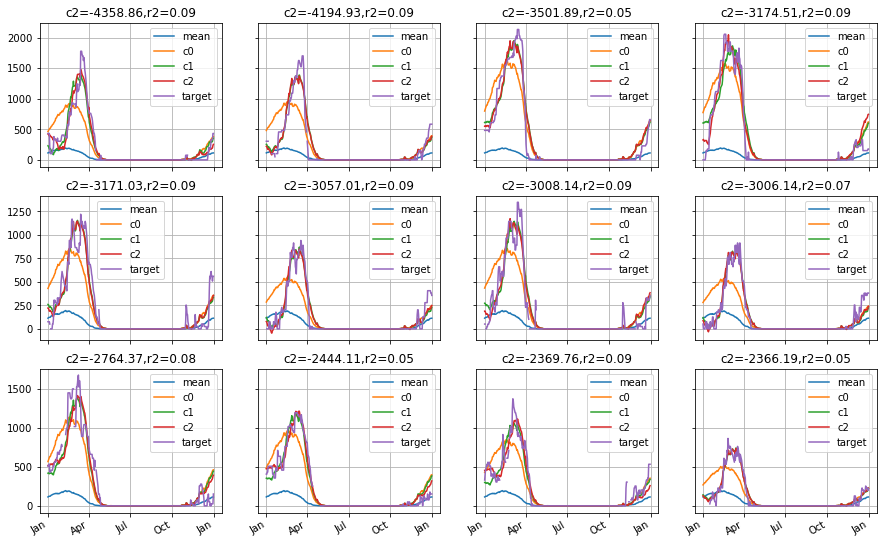

In [132]:
plot_recon_grid(all_rows[:12],Mean,EigVec)
savefig('r_figures/SNWD_grid_negative_coeff_2.png')

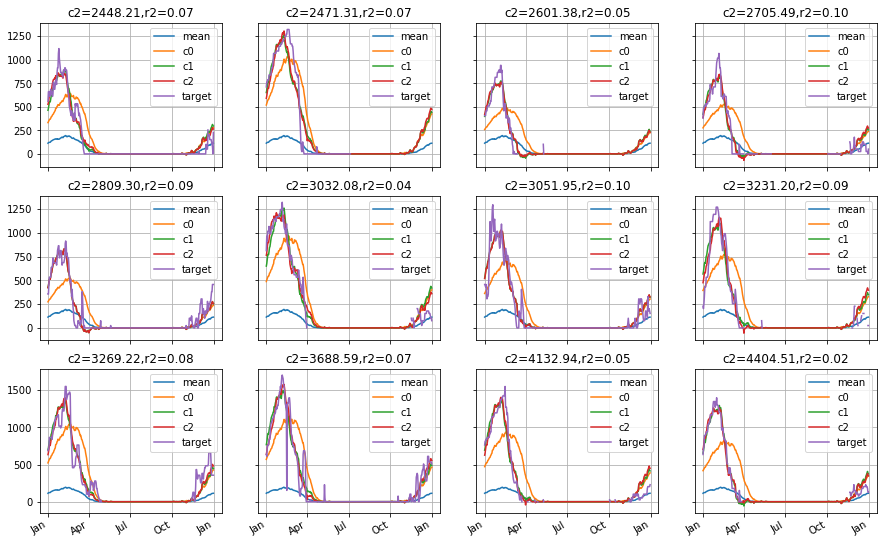

In [133]:
plot_recon_grid(all_rows[-12:],Mean,EigVec)
savefig('r_figures/SNWD_grid_positive_coeff_2.png')

### Studying the effect of Coefficient 3

In [134]:
df4=df3.filter(df3.res_3<0.1).sort(df3.coeff_3)
print(df4.count())
all_rows=df4.collect()
rows=all_rows[:12]

324


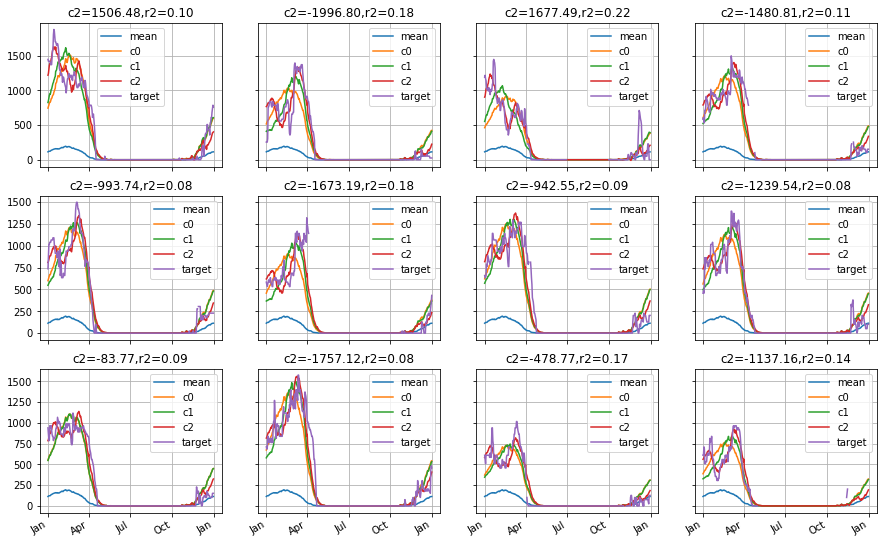

In [135]:
plot_recon_grid(all_rows[:12],Mean,EigVec)
savefig('r_figures/SNWD_grid_negative_coeff_3.png')

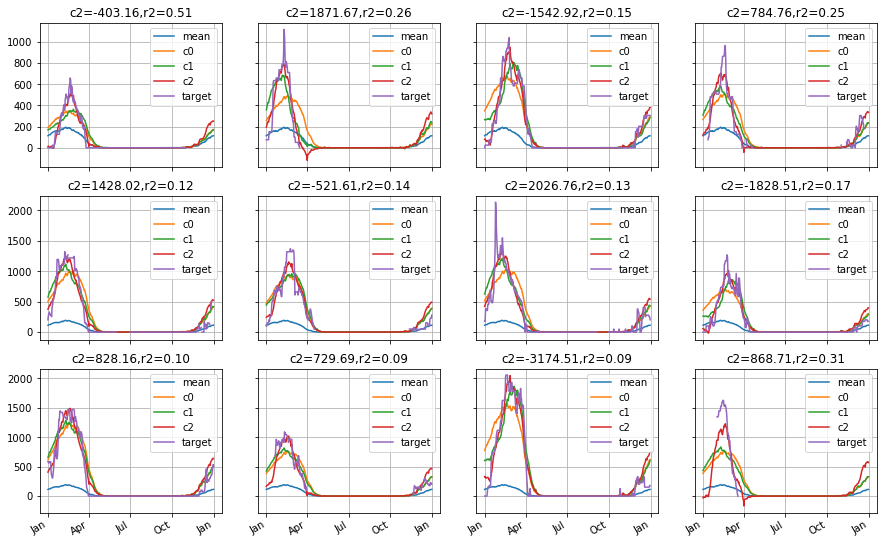

In [136]:
plot_recon_grid(all_rows[-12:],Mean,EigVec)

In [137]:
df4=df3.sort(df3.res_3)
print(df4.count())
all_rows=df4.collect()
df4.select('coeff_1','coeff_2','coeff_3','res_3').show(n=4,truncate=14)

8174
+--------------+--------------+--------------+--------------+
|       coeff_1|       coeff_2|       coeff_3|         res_3|
+--------------+--------------+--------------+--------------+
|6671.358980...|-1651.46745...|-561.841928...|0.020110417...|
|5052.236768...|4404.510874...|-362.489777...|0.020525853...|
|5924.750266...|-1034.99396...|-119.732078...|0.022097266...|
|8393.054466...|-1384.16864...|-423.096239...|0.022246089...|
+--------------+--------------+--------------+--------------+
only showing top 4 rows



### Best Fit

First, SNWD sequences are plotted, which are best approximated using the first three eigen-vectors. In other words, the sequences for which the third residual is smallest. These can be thought of as **architypical** sequences.

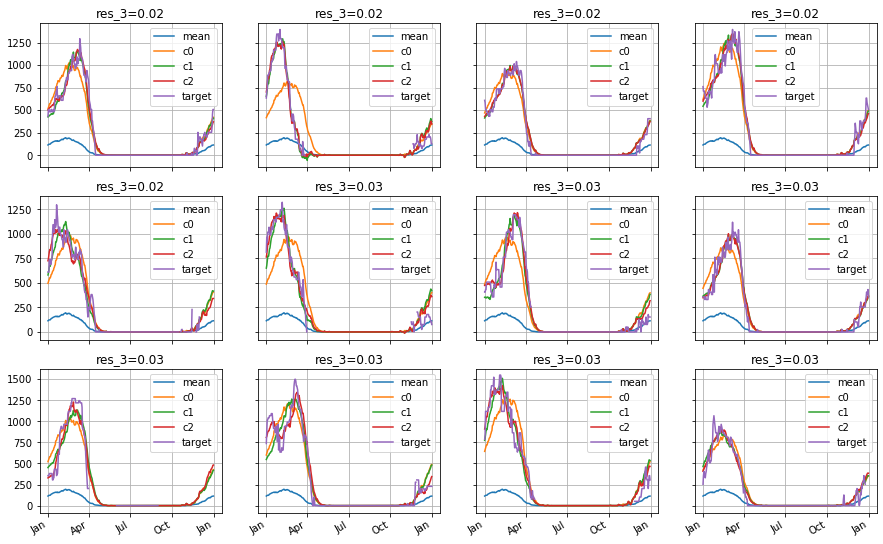

In [138]:
plot_recon_grid(all_rows[:12],Mean,EigVec,header='res_3=%3.2f', params=('res_3',))

## Worst fit

Next, the sequence whose third residual is largest are looked at. These can be thought of as **outliers** or **noise**. These seuqnces do not fit the model. 

If there are many of these outliers, there is either poor data, or the model is inadequate.

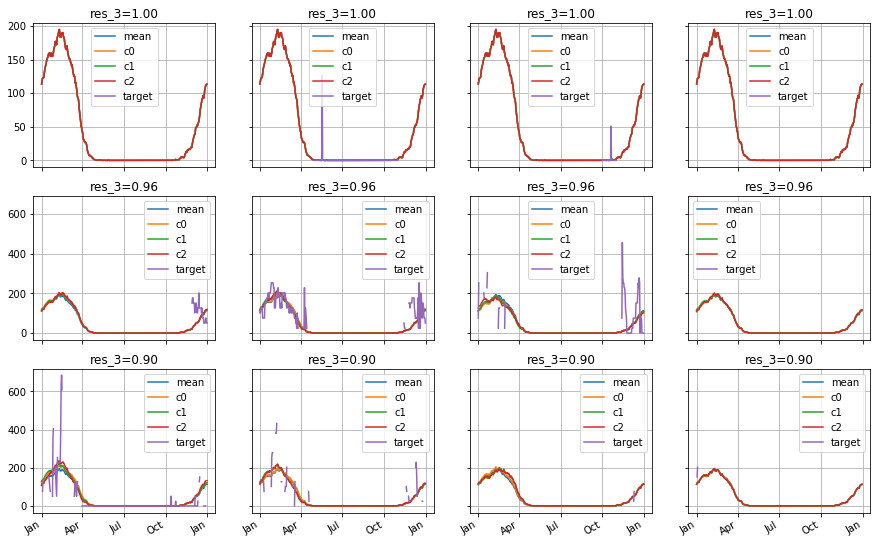

In [139]:
bad_rows=all_rows[-4:]+all_rows[-504:-500]+all_rows[-1004:-1000]
plot_recon_grid(bad_rows,Mean,EigVec,header='res_3=%3.2f', params=('res_3',))

Clearly, the majority of the poor fits are a result of undefined entries in the data.  

## Studying the distribution of the coefficients.

To answer this, all of the values of `res_3` can be extracted, which is the residual variance after the Mean and the first two Eigen-vectors have been subtracted out. Here, the fact that `df3` is already sorted according to `res_3` is relied on.

In [141]:
pdf=df3.select(['Station','Year','coeff_1','coeff_2','coeff_3','res_1','res_2','res_3','res_mean','total_var']).toPandas()

In [142]:
pdf.columns

Index(['Station', 'Year', 'coeff_1', 'coeff_2', 'coeff_3', 'res_1', 'res_2',
       'res_3', 'res_mean', 'total_var'],
      dtype='object')

In [143]:
#pdf=pdf.set_index('Year')
#pdf.head()

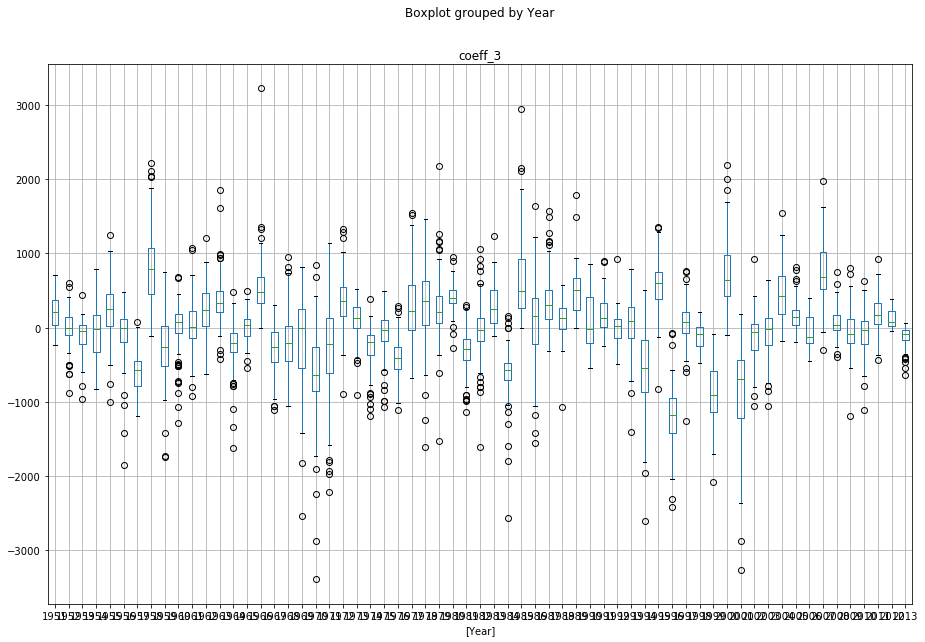

In [144]:
pdf[['Year','coeff_3']][pdf['Year']>1950].boxplot(by='Year',figsize=[15,10])

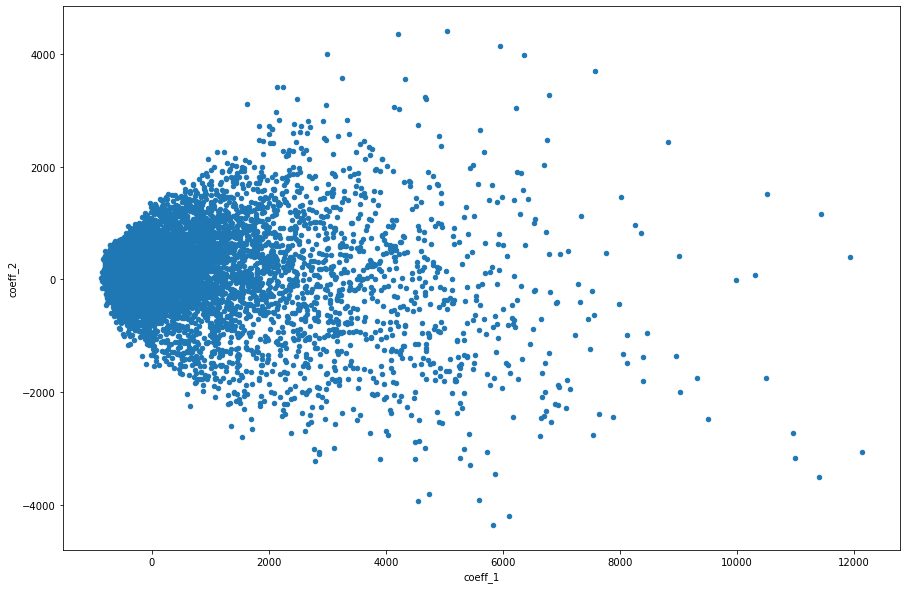

In [145]:
pdf.plot.scatter('coeff_1','coeff_2',figsize=[15,10])

In [146]:
grpby=pdf.groupby('Year')['coeff_1']
ratio=grpby.mean()/grpby.std()
np.nanmax(ratio),np.nanmin(ratio)

(1.0582367314744348, -0.933331325246963)

In [147]:
#function for plotting CDF of a given feature
def plot_CDF(feat):
    rows=df4.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)+1))
    vals=[vals[0]]+vals
    axis.plot(vals,P,label=feat)

In [148]:
df4.columns

['Station',
 'Measurement',
 'Values',
 'Year',
 'coeff_1',
 'coeff_2',
 'coeff_3',
 'coeff_4',
 'coeff_5',
 'dist_coast',
 'elevation',
 'latitude',
 'longitude',
 'name',
 'res_1',
 'res_2',
 'res_3',
 'res_4',
 'res_5',
 'res_mean',
 'total_var',
 'State']

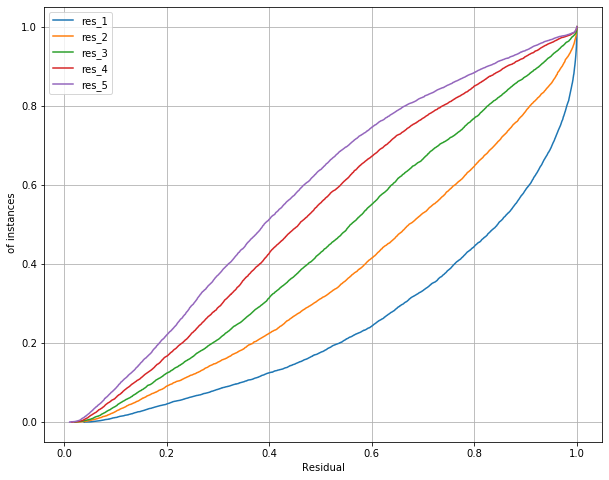

In [149]:
figure(figsize=(10,8))
axis=gca()

#plot_CDF('res_mean') # why does this not fit?
plot_CDF('res_1')
plot_CDF('res_2')
plot_CDF('res_3')
plot_CDF('res_4')
plot_CDF('res_5')
ylabel(' of instances')
xlabel('Residual')
grid()
legend()

In [150]:
plot_CDF('coeff_1')
savefig('r_figures/SNWD_coeff_3_CDF.png')

<Figure size 432x288 with 0 Axes>

In [151]:
plot_CDF('coeff_2')
savefig('r_figures/SNWD_coeff_3_CDF.png')

<Figure size 432x288 with 0 Axes>

In [152]:
plot_CDF('coeff_3')
savefig('r_figures/SNWD_coeff_3_CDF.png')

<Figure size 432x288 with 0 Axes>

In [153]:
filename=data_dir+'/recon_'+state+'_'+m+'.parquet'
!rm -rf $filename
df3.write.parquet(filename)

!du -sh $data_dir/*.parquet

103M	Data/Weather/Joined_smoothed_PRCP.parquet
 76M	Data/Weather/NY.parquet
 13M	Data/Weather/decon_NY_PRCP_s20.parquet
1.9M	Data/Weather/decon_NY_SNWD.parquet
1.9M	Data/Weather/recon_NY_SNWD.parquet
416K	Data/Weather/stations.parquet


In [154]:
#setup
data_dir='Data/Weather'
#!ls $data_dir
state='NY'
m='PRCP_s20'

## Spectral Analysis of smoothed PRCP

In [155]:
#enable automatic reload of libraries
%load_ext autoreload
%autoreload 2 #means all modules are reloaded before every command

%pylab inline
#%pylab inline
import numpy as np

import findspark
findspark.init()

from lib.numpy_pack import packArray,unpackArray

#from lib.Eigen_decomp import Eigen_decomp
from lib.YearPlotter import YearPlotter
from lib.decomposer import *
from lib.Reconstruction_plots import *


from lib.import_modules import import_modules,modules
import_modules(modules)

from lib.getFiles import *

import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual,widgets
import ipywidgets as widgets

print('version of ipwidgets=',widgets.__version__)

import warnings 
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=1.0.0 	required version>=0.19.2

     numpy as    np 	version=1.18.1 	required version>=1.12.0

   sklearn as    sk 	version=0.22.1 	required version>=0.18.1

module urllib has no version
   pyspark as pyspark 	version=2.4.5 	required version>=2.1.0

ipywidgets as ipywidgets 	version=7.5.1 	required version>=6.0.0

version of ipwidgets= 7.5.1


In [156]:
from pyspark import SparkContext
sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStatistics.py','lib/Reconstruction_plots.py','lib/decomposer.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

### Read Statistics File

In [157]:
get_weather_files(state,data_dir)
!du -h $data_dir

103M	Data/Weather/Joined_smoothed_PRCP.parquet
 13M	Data/Weather/decon_NY_PRCP_s20.parquet
 76M	Data/Weather/NY.parquet
416K	Data/Weather/stations.parquet
1.9M	Data/Weather/decon_NY_SNWD.parquet
1.9M	Data/Weather/recon_NY_SNWD.parquet
310M	Data/Weather


In [158]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%state
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print('keys from STAT=',measurements)

keys from STAT= dict_keys(['SNOW_s20', 'TMIN_s20', 'TOBS', 'SNWD_s20', 'PRCP_s20', 'TOBS_s20', 'PRCP', 'TMAX', 'TMAX_s20', 'TMIN', 'SNOW', 'SNWD'])


In [159]:
EigVec=STAT[m]['eigvec']
Mean=STAT[m]['Mean']

### Read data file into a spark DataFrame

In [160]:
#read data
filename=data_dir+'/%s.parquet'%state
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.Measurement==m)
df=df.drop('State')
df.show(5)

+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----------------+
|    Station|Measurement|Year|              Values|       dist_coast|      latitude|         longitude|        elevation|             name|
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----------------+
|USW00094704|   PRCP_s20|1945|[00 00 00 00 00 0...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1946|[99 46 52 46 0B 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1947|[79 4C 75 4C 8F 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1948|[72 48 7A 48 85 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|DANSVILLE MUNI AP|
|USW00094704|   PRCP

## Computing decomposition for each row, and add columns for coefficients and residuals

In [161]:
%%time
k=5
df2=decompose_dataframe(sqlContext,df,EigVec[:,:k],Mean).cache() # Make it possible to generate only first k coefficients.

CPU times: user 13.6 ms, sys: 2.45 ms, total: 16 ms
Wall time: 418 ms


In [162]:
%%time
print(df2.count())

16118
CPU times: user 1.65 ms, sys: 1.31 ms, total: 2.96 ms
Wall time: 2.16 s


In [163]:
df2.show(1)

+-----------+-----------+--------------------+----+-----------------+----------------+-------------------+-----------------+-----------------+-----------------+-----------------+--------------+------------------+-----------------+-----------------+------------------+------------------+------------------+-------------------+------------------+-----------------+
|Measurement|    Station|              Values|Year|          coeff_1|         coeff_2|            coeff_3|          coeff_4|          coeff_5|       dist_coast|        elevation|      latitude|         longitude|             name|            res_1|             res_2|             res_3|             res_4|              res_5|          res_mean|        total_var|
+-----------+-----------+--------------------+----+-----------------+----------------+-------------------+-----------------+-----------------+-----------------+-----------------+--------------+------------------+-----------------+-----------------+------------------+-------

### Saving the decomposition in a Parquet file

In [164]:
df2.count()

16118

In [165]:
filename=data_dir+'/decon_'+state+'_'+m+'.parquet'
!rm -rf $filename
filename

'Data/Weather/decon_NY_PRCP_s20.parquet'

In [166]:
df2.write.parquet(filename)

In [167]:
!du -sh $data_dir/*.parquet

103M	Data/Weather/Joined_smoothed_PRCP.parquet
 76M	Data/Weather/NY.parquet
 13M	Data/Weather/decon_NY_PRCP_s20.parquet
1.9M	Data/Weather/decon_NY_SNWD.parquet
1.9M	Data/Weather/recon_NY_SNWD.parquet
416K	Data/Weather/stations.parquet


## Plot mean and top eigenvectors

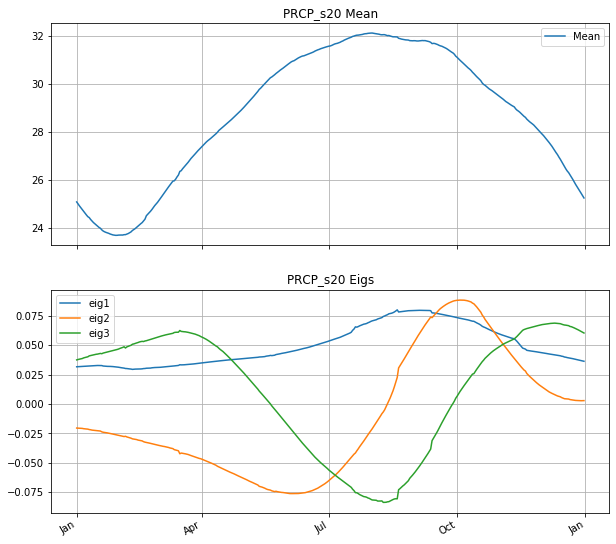

In [168]:
import pylab as plt
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,10));
k=3
EigVec=np.array(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

## Plot percentage of variance explained

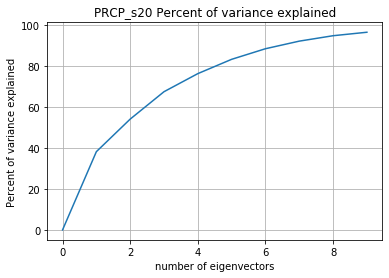

In [169]:
# x=0 in graphs below correspond to fraction of variance explained by mean alone
# x=1,2,3,... are residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=np.cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title(m+' Percent of variance explained');

## Exploring the decomposition

### Intuitive analysis

In [170]:
#combine mean with Eigvecs and scale to similar range.
print(EigVec.shape)
_norm_Mean=Mean/max(Mean)*0.2
A=[_norm_Mean]+[EigVec[:,i] for i in range(EigVec.shape[1])]
Combined=np.stack(A).transpose()
Combined.shape

(365, 3)


(365, 4)

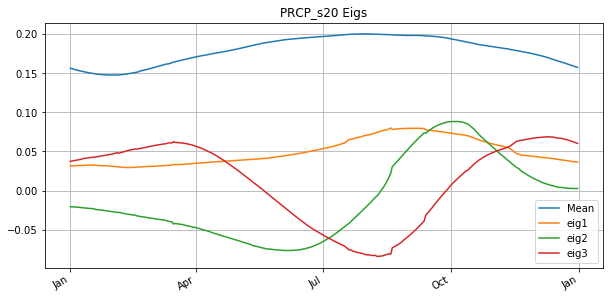

In [171]:
import pylab as plt
fig,axes=plt.subplots(1,1, sharex='col', sharey='row',figsize=(10,5));
k=3
EigVec=np.array(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
#YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(Combined,fig,axes,title=m+' Eigs',labels=['Mean']+['eig'+str(i+1) for i in range(k)])

### Studying the effect of Coefficient 1

In [172]:
df4=df2.filter(df2.res_2<0.1).sort(df2.coeff_1)
print(df4.count())
all_rows=df4.collect()
rows=all_rows[:12]

357


In [173]:
# Checking that res_2 is smaller than 0.1 and that rows are sorted based on coeff_2
df4.select('coeff_1','coeff_2','coeff_3','res_1','res_2','res_3',).show(n=4,truncate=14)

+--------------+--------------+--------------+--------------+--------------+--------------+
|       coeff_1|       coeff_2|       coeff_3|         res_1|         res_2|         res_3|
+--------------+--------------+--------------+--------------+--------------+--------------+
|-496.170514...|142.0891167...|-53.8503229...|0.070859013...|0.031252717...|0.011871730...|
|-391.468556...|63.07175638...|-23.9930865...|0.105514602...|0.082295290...|0.078935194...|
|-372.309500...|103.3110146...|-34.7105415...|0.115436660...|0.047326178...|0.039637645...|
|-343.775186...|-60.1073774...|0.905112531...|0.090687811...|0.062889429...|0.062883126...|
+--------------+--------------+--------------+--------------+--------------+--------------+
only showing top 4 rows



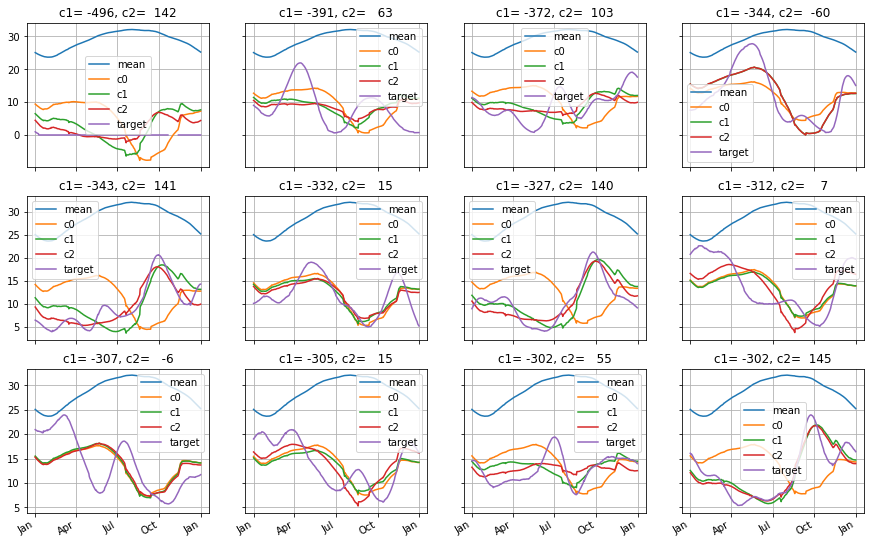

In [174]:
plot_recon_grid(all_rows[:12],Mean,EigVec,header='c1=%5.0f, c2=%5.0f',params=('coeff_1','coeff_2'))
savefig('r_figures/SNWD_grid_negative_coeff_2.png')

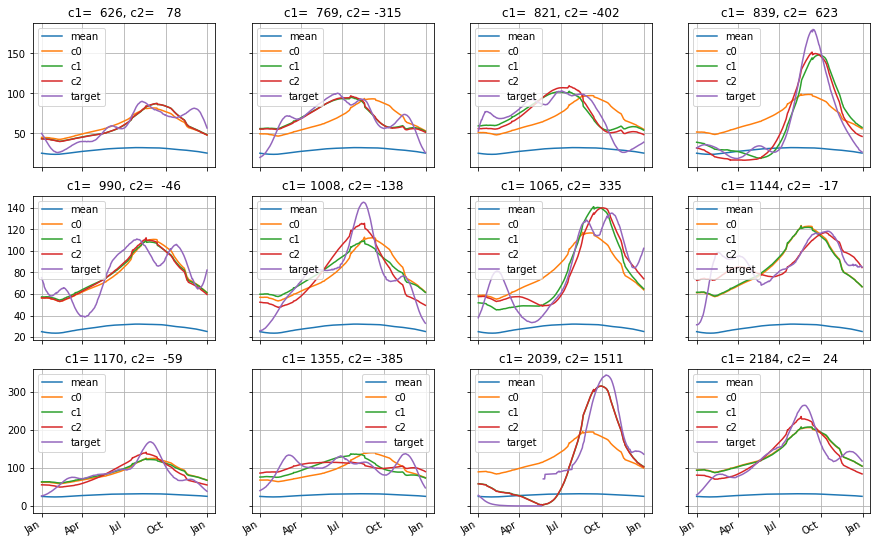

In [175]:
plot_recon_grid(all_rows[-12:],Mean,EigVec,header='c1=%5.0f, c2=%5.0f',params=('coeff_1','coeff_2'))
savefig('r_figures/SNWD_grid_positive_coeff_2.png')

### Studying the effect of Coefficient 2

In [176]:
df4=df2.filter(df2.res_2<0.1).sort(df2.coeff_2)
print(df4.count())
all_rows=df4.collect()
rows=all_rows[:12]

357


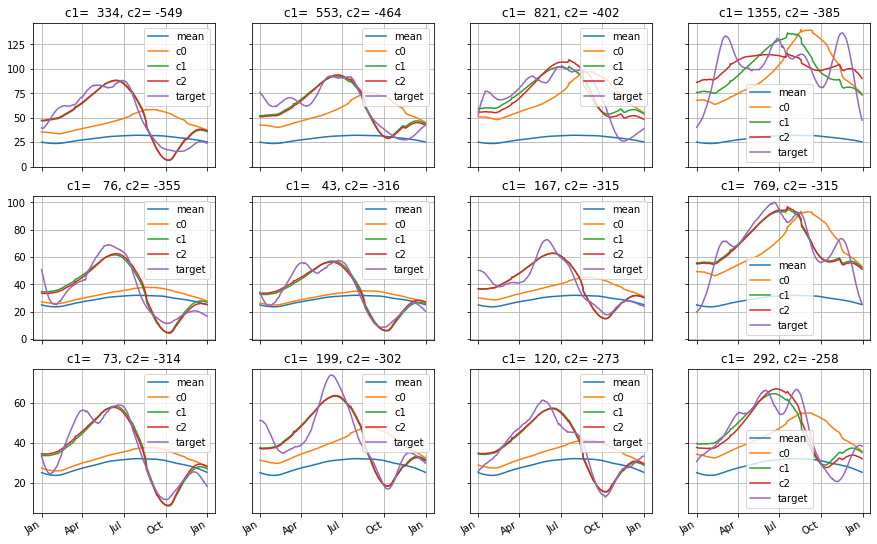

In [177]:
plot_recon_grid(all_rows[:12],Mean,EigVec,header='c1=%5.0f, c2=%5.0f',params=('coeff_1','coeff_2'))
savefig('r_figures/SNWD_grid_negative_coeff_3.png')

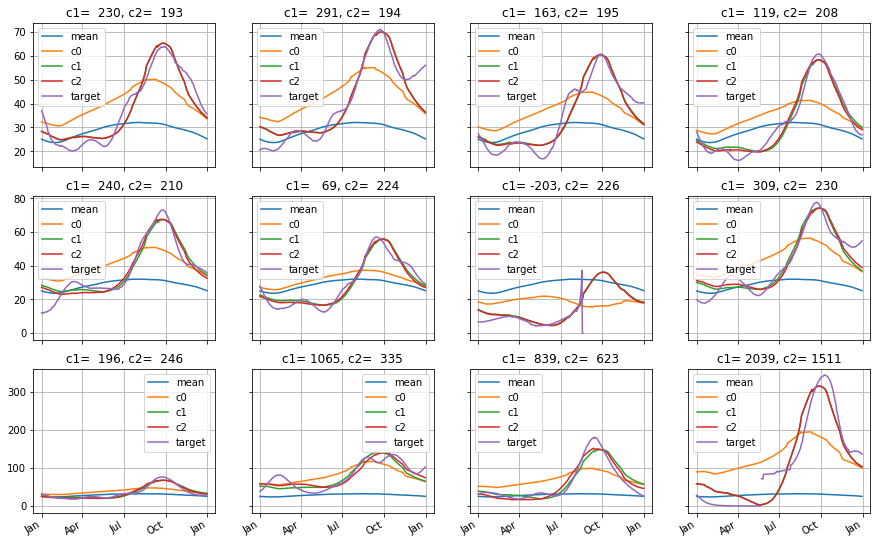

In [178]:
plot_recon_grid(all_rows[-12:],Mean,EigVec,header='c1=%5.0f, c2=%5.0f',params=('coeff_1','coeff_2'))

### Best Fit

In [179]:
df4=df2.sort(df2.res_3)
print(df4.count())
all_rows=df4.collect()
df4.select('coeff_1','coeff_2','coeff_3','res_3').show(n=4,truncate=14)

16118
+--------------+--------------+--------------+--------------+
|       coeff_1|       coeff_2|       coeff_3|         res_3|
+--------------+--------------+--------------+--------------+
|-343.269300...|140.7673740...|-53.7203309...|0.009187131...|
|-296.409032...|24.91257375...|-53.5830828...|0.010476257...|
|-326.579941...|140.3915431...|-33.6786687...|0.011599174...|
|-496.170514...|142.0891167...|-53.8503229...|0.011871730...|
+--------------+--------------+--------------+--------------+
only showing top 4 rows



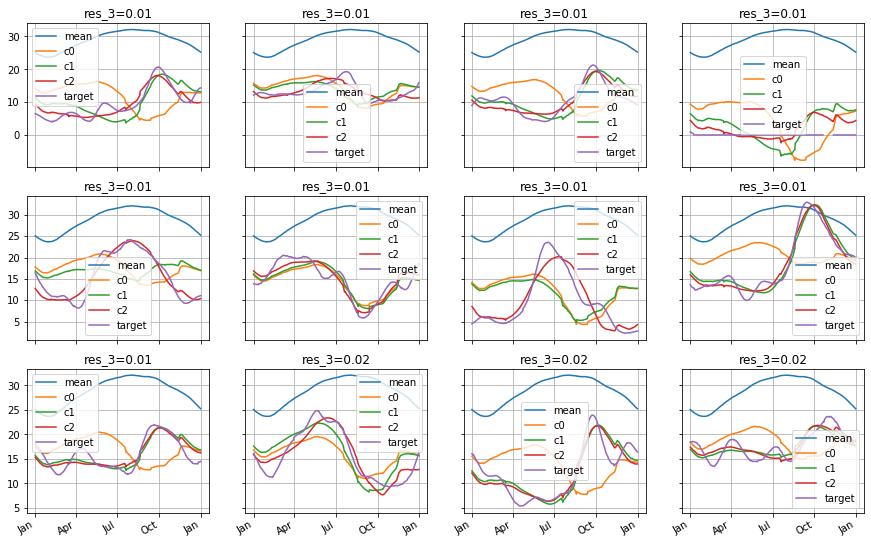

In [180]:
plot_recon_grid(all_rows[:12],Mean,EigVec,header='res_3=%3.2f', params=('res_3',))

## Worst fit

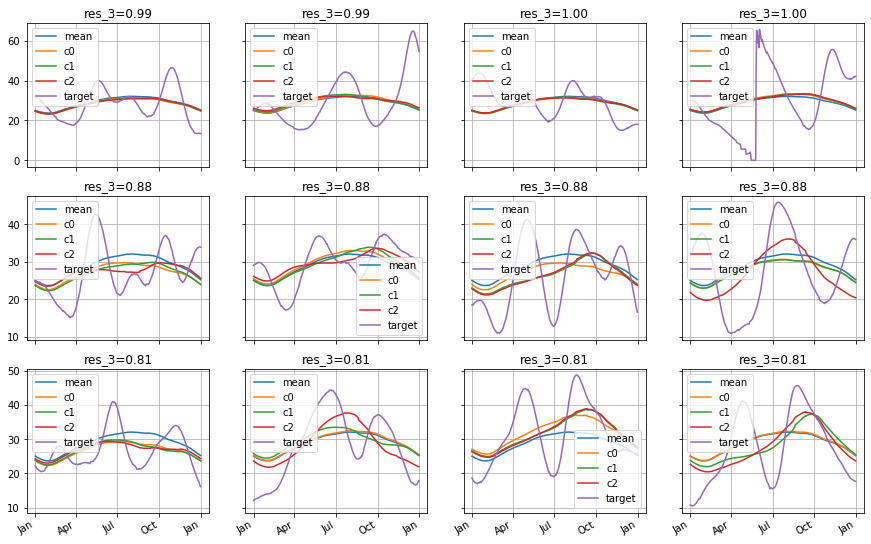

In [181]:
bad_rows=all_rows[-4:]+all_rows[-504:-500]+all_rows[-1004:-1000]
plot_recon_grid(bad_rows,Mean,EigVec,header='res_3=%3.2f', params=('res_3',))

In [183]:
!ls Data/Weather/

Joined_smoothed_PRCP.parquet Weather_Stations.tgz
NY.parquet                   decon_NY_PRCP_s20.parquet
NY.tgz                       decon_NY_SNWD.parquet
STAT_NY.pickle               recon_NY_SNWD.parquet
US_stations.tsv              stations.parquet


In [184]:
import ipyleaflet
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [185]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualising the distribution coefficients on a map

In [186]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [187]:
import findspark
findspark.init()

from pyspark import SparkContext
sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStatistics.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [188]:
import numpy as np
from lib.numpy_pack import packArray,unpackArray
from lib.spark_PCA import computeCov
from lib.computeStatistics import *

###  Load stations information

In [189]:
data_dir='Data/Weather/'
!du -sh $data_dir/*

103M	Data/Weather//Joined_smoothed_PRCP.parquet
 76M	Data/Weather//NY.parquet
 64M	Data/Weather//NY.tgz
 49M	Data/Weather//STAT_NY.pickle
716K	Data/Weather//US_stations.tsv
384K	Data/Weather//Weather_Stations.tgz
 13M	Data/Weather//decon_NY_PRCP_s20.parquet
1.9M	Data/Weather//decon_NY_SNWD.parquet
1.9M	Data/Weather//recon_NY_SNWD.parquet
416K	Data/Weather//stations.parquet


In [190]:
stations_df=sqlContext.read.parquet(data_dir+'/stations.parquet')
stations_df.show(3)

+-----------+----------+--------+---------+---------+-----+----------------+
|    Station|Dist_coast|Latitude|Longitude|Elevation|State|            Name|
+-----------+----------+--------+---------+---------+-----+----------------+
|USC00341900|   739.956|    36.3| -96.4667|    242.3|   OK|       CLEVELAND|
|USC00428114|    908.22|    40.1|-111.6667|   1409.1|   UT|SPANISH FORK 1 S|
|USC00165926|   23.8801| 29.7853| -90.1158|      0.9|   LA|   MARRERO 9 SSW|
+-----------+----------+--------+---------+---------+-----+----------------+
only showing top 3 rows



### Load the reconstructions DataFrame

In [191]:
#read dataframe from parquet file
state='NY'
meas='SNWD'

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(state,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(1)

8174
+-----------+-----------+--------------------+----+------------------+-------------------+------------------+------------------+------------------+------------------+----------------+------------------+------------------+---------+------------------+------------------+------------------+------------------+-------------------+------------------+---------+-----+
|    Station|Measurement|              Values|Year|           coeff_1|            coeff_2|           coeff_3|           coeff_4|           coeff_5|        dist_coast|       elevation|          latitude|         longitude|     name|             res_1|             res_2|             res_3|             res_4|              res_5|          res_mean|total_var|State|
+-----------+-----------+--------------------+----+------------------+-------------------+------------------+------------------+------------------+------------------+----------------+------------------+------------------+---------+------------------+------------------+

## Compute the count and average of `coef_1` for each station.

In [192]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,Dist_coast,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)

df2=df1.groupby(['station','latitude','longitude','elevation','Dist_coast']).agg({"station": "count", feature: "mean"})
#df2=df1.groupby(['station']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(5)

SELECT station, latitude,longitude,elevation,Dist_coast,coeff_1 FROM weather


station   latitude  longitude   elevation  Dist_coast  \
294  USC00300015  43.900002 -76.066704  121.900002  376.802002   
182  USC00300023  42.101398 -77.234398  304.500000  296.167999   
275  USC00300047  42.646099 -73.747200    0.000000  166.001007   
69   USC00300055  43.272202 -78.166397  134.100006  436.303009   
239  USC00300063  42.469700 -73.926697  185.000000  152.889999   

     count(station)  avg(coeff_1)  
294              25   1550.908341  
182              46    -90.305486  
275               4   -107.478530  
69               29     43.864554  
239               5     -6.938177

In [193]:
#find long/lat bounding box
max_long=pdf['longitude'].max()
min_long=pdf['longitude'].min()
max_lat=pdf['latitude'].max()
min_lat=pdf['latitude'].min()

In [194]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

## Map
* Each circle is centered at a station.  
* The area of the circle corresponds to the number of years SNWD was recorded at the station.  
* The color fill of the circle corresponds to the value of `avg(coeff_1)` defined by color-bar.

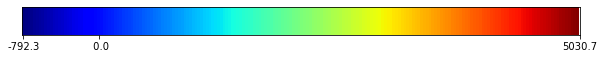

In [195]:
#def color_bar(_min,_max)
import pylab as plt
from matplotlib.pyplot import xticks,yticks
figure(figsize=[10,1])
ax = plt.subplot(111)
vals=cmap(np.arange(0,1,0.005))[:,:3]
vals3=np.stack([vals]*10)
vals3.shape
ax.imshow(vals3);

midpoint=200.*-_min/(_max-_min)
xticks((0,midpoint,200),["%4.1f"%v for v in (_min,0.,_max)])
yticks(());

In [196]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 6

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(1200*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m    

Map(center=[42.75955009460449, -75.94625091552734], controls=(ZoomControl(options=['position', 'zoom_in_text',…

### Is coef_1 related to elevation?

(-100, 1000)

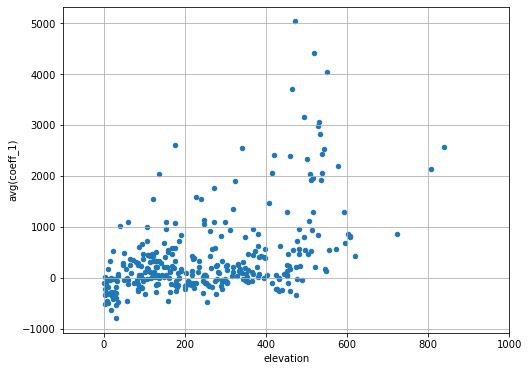

In [197]:
pdf.plot.scatter(x='elevation',y='avg(coeff_1)',figsize=(8,6));
grid()
xlim([-100,1000])

## Analyse whether early or late snow changes more year to year or place to place.

* The value of `coef_2` corresponds to whether the snow season is early or late. 
* To study whether early/late season is more dependent on the year or on the location, RMS Error is used to quantify the strength of these dependencies.

In [198]:
import pandas as pd
import numpy as np
import urllib
import math

In [199]:
import findspark
findspark.init()

from pyspark import SparkContext
sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStatistics.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [200]:
%pylab inline
import numpy as np
from lib.numpy_pack import packArray,unpackArray
from lib.spark_PCA import computeCov
from lib.computeStatistics import *

Populating the interactive namespace from numpy and matplotlib


In [202]:
#read dataframe from pickle file
data_dir='Data/Weather'
state='NY'
meas='SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%state
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

keys from STAT= dict_keys(['SNOW_s20', 'TMIN_s20', 'TOBS', 'SNWD_s20', 'PRCP_s20', 'TOBS_s20', 'PRCP', 'TMAX', 'TMAX_s20', 'TMIN', 'SNOW', 'SNWD'])


In [203]:
#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(state,meas)

df=sqlContext.read.parquet(filename)
print(df.count())

8174


In [204]:
tmp=df.filter(df.Station=='USC00306411').toPandas()
tmp.head(1)

Station Measurement                                             Values  \
0  USC00306411        SNWD  [0, 126, 0, 126, 0, 126, 0, 126, 0, 126, 0, 12...   

   Year   coeff_1   coeff_2   coeff_3    coeff_4   coeff_5  dist_coast  ...  \
0  1941  1.335004  1.636196  20.11617 -19.059189 -6.872523  370.621002  ...   

   longitude               name     res_1     res_2     res_3     res_4  \
0 -74.833298  PARISHVILLE 1 WNW  0.999985  0.999962  0.996677  0.995718   

      res_5  res_mean  total_var  State  
0  0.995049  0.538214   433356.0     NY  

[1 rows x 22 columns]

In [205]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Features='station, year, coeff_2'
Query="SELECT %s FROM weather"%Features
print(Query)
pdf = sqlContext.sql(Query).toPandas()
pdf.head()

SELECT station, year, coeff_2 FROM weather


station  year      coeff_2
0  USW00014735  1939  -169.322319
1  USW00014735  1943   272.354092
2  USW00014735  1945   790.579389
3  USW00014735  1947  -216.302832
4  USW00014735  1948  1028.612179

In [206]:
year_station_table=pdf.pivot(index='year', columns='station', values='coeff_2')
year_station_table.tail(5)

station  USC00300015  USC00300023  USC00300047  USC00300055  USC00300063  \
year                                                                       
2009             NaN          NaN          NaN          NaN          NaN   
2010             NaN          NaN          NaN          NaN          NaN   
2011             NaN          NaN          NaN  -120.642691   472.534062   
2012             NaN          NaN          NaN          NaN          NaN   
2013             NaN   149.013363          NaN          NaN     0.977231   

station  USC00300077  USC00300085  USC00300090  USC00300093  USC00300159  ...  \
year                                                                      ...   
2009             NaN          NaN          NaN   870.773867          NaN  ...   
2010             NaN          NaN          NaN   -31.805303          NaN  ...   
2011             NaN          NaN          NaN   907.925667          NaN  ...   
2012             NaN          NaN          NaN          NaN          NaN  ...   
2013             NaN    97.643753          NaN          NaN          NaN  ...   

station  USW00014786  USW00014797  USW00014798  USW00094704  USW00094725  \
year                                                                       
2009             NaN          NaN          NaN          NaN          NaN   
2010             NaN          NaN          NaN          NaN          NaN   
2011             NaN          NaN          NaN          NaN          NaN   
2012             NaN          NaN          NaN          NaN          NaN   
2013             NaN          NaN          NaN          NaN          NaN   

station  USW00094728  USW00094745  USW00094789  USW00094790  USW00094794  
year                                                                      
2009             NaN          NaN          NaN          NaN          NaN  
2010             NaN          NaN          NaN          NaN          NaN  
2011      806.258001          NaN          NaN          NaN          NaN  
2012             NaN          NaN          NaN          NaN          NaN  
2013             NaN          NaN          NaN          NaN          NaN  

[5 rows x 329 columns]

Text(0, 0.5, 'Number of stations')

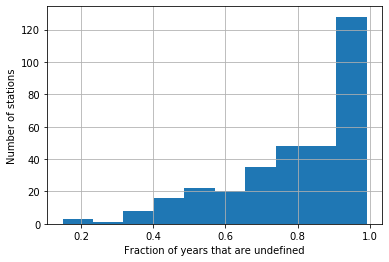

In [207]:
station_nulls=pd.isnull(year_station_table).mean()
station_nulls.hist();
xlabel('Fraction of years that are undefined')
ylabel('Number of stations')

Text(0, 0.5, 'fraction of stations that are undefined')

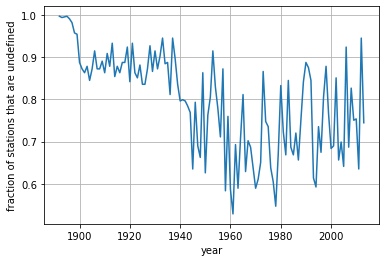

In [208]:
year_nulls=pd.isnull(year_station_table).mean(axis=1)
year_nulls.plot();
grid()
ylabel('fraction of stations that are undefined')

In [209]:
pdf2=pdf[pdf['year']>1960]
year_station_table=pdf2.pivot(index='year', columns='station', values='coeff_2')
year_station_table.tail(5)

station  USC00300023  USC00300055  USC00300063  USC00300077  USC00300085  \
year                                                                       
2009             NaN          NaN          NaN          NaN          NaN   
2010             NaN          NaN          NaN          NaN          NaN   
2011             NaN  -120.642691   472.534062          NaN          NaN   
2012             NaN          NaN          NaN          NaN          NaN   
2013      149.013363          NaN     0.977231          NaN    97.643753   

station  USC00300093  USC00300183  USC00300220  USC00300321  USC00300331  ...  \
year                                                                      ...   
2009      870.773867   576.598705          NaN   580.459651          NaN  ...   
2010      -31.805303   -25.393217          NaN  -188.964850  -531.836350  ...   
2011      907.925667   305.092413          NaN   561.781691   566.875416  ...   
2012             NaN          NaN          NaN          NaN          NaN  ...   
2013             NaN          NaN          NaN   170.083352    43.373130  ...   

station  USW00014768  USW00014771  USW00014786  USW00014798  USW00094725  \
year                                                                       
2009             NaN   627.812099          NaN          NaN          NaN   
2010     -177.099611   156.548016          NaN          NaN          NaN   
2011      283.597976   584.134272          NaN          NaN          NaN   
2012             NaN          NaN          NaN          NaN          NaN   
2013       15.194207    86.764841          NaN          NaN          NaN   

station  USW00094728  USW00094745  USW00094789  USW00094790  USW00094794  
year                                                                      
2009             NaN          NaN          NaN          NaN          NaN  
2010             NaN          NaN          NaN          NaN          NaN  
2011      806.258001          NaN          NaN          NaN          NaN  
2012             NaN          NaN          NaN          NaN          NaN  
2013             NaN          NaN          NaN          NaN          NaN  

[5 rows x 268 columns]

Text(0, 0.5, 'Number of stations')

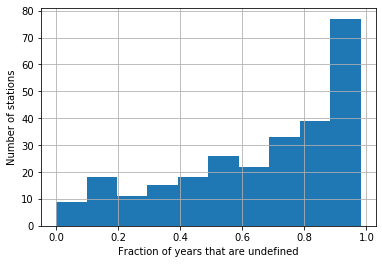

In [210]:
station_nulls=pd.isnull(year_station_table).mean()
station_nulls.hist();
xlabel('Fraction of years that are undefined')
ylabel('Number of stations')

### Estimating the effect of the year vs the effect of the station

To estimate the effect of time vs. location on the second eigenvector coefficient the following is computed:

* The average row: `mean-by-station`
* The average column: `mean-by-year`

Then the RMS before and after subtracting either the row or the column vector is computed.

In [211]:
def RMS(Mat):
    return np.sqrt(np.nanmean(Mat**2))

mean_by_year=np.nanmean(year_station_table,axis=1)
mean_by_station=np.nanmean(year_station_table,axis=0)
tbl_minus_year = (year_station_table.transpose()-mean_by_year).transpose()
tbl_minus_station = year_station_table-mean_by_station

print('total RMS                   = ',RMS(year_station_table))
print('RMS removing mean-by-station= ',RMS(tbl_minus_station),'reduction=',RMS(year_station_table)-RMS(tbl_minus_station))
print('RMS removing mean-by-year   = ',RMS(tbl_minus_year),'reduction=',RMS(year_station_table)-RMS(tbl_minus_year))

total RMS                   =  753.145449514645
RMS removing mean-by-station=  701.5445524111517 reduction= 51.60089710349325
RMS removing mean-by-year   =  531.4823870967627 reduction= 221.6630624178822


### Conclusion Of Analysis
The effect of time is about four times as large as the effect of location.

### Iterative reduction
* After removing one component, the other component can have an effect.
* **Alternating minimisation** can be used to remove the combined effect of location and time.

In [212]:
T=year_station_table
print('initial RMS=',RMS(T))
for i in range(5):
    mean_by_year=np.nanmean(T,axis=1)
    T=(T.transpose()-mean_by_year).transpose()
    print(i,'after removing mean by year    =',RMS(T))
    mean_by_station=np.nanmean(T,axis=0)
    T=T-mean_by_station
    print(i,'after removing mean by stations=',RMS(T))

initial RMS= 753.145449514645
0 after removing mean by year    = 531.4823870967627
0 after removing mean by stations= 490.58111029852466
1 after removing mean by year    = 490.1114939479562
1 after removing mean by stations= 490.08333935027764
2 after removing mean by year    = 490.08010695597295
2 after removing mean by stations= 490.0794679008307
3 after removing mean by year    = 490.0793022334803
3 after removing mean by stations= 490.0792548676868
4 after removing mean by year    = 490.0792408655066
4 after removing mean by stations= 490.07923667584663


In [213]:
T['mean_by_year']=mean_by_year
T['mean_by_year'].head()

year
1961   -0.115733
1962   -0.142607
1963   -0.143292
1964   -0.149812
1965   -0.130511
Name: mean_by_year, dtype: float64

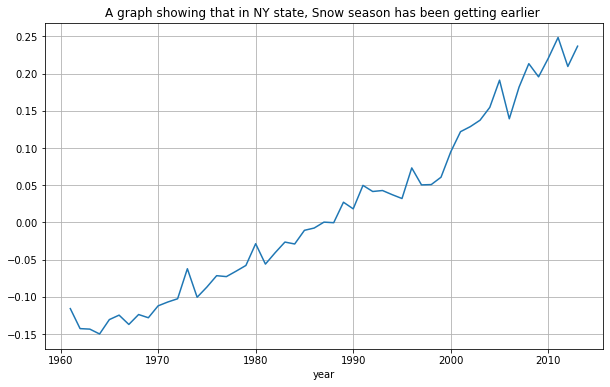

In [214]:
figure(figsize=(10,6))
T['mean_by_year'].plot();
grid()
title('A graph showing that in NY state, Snow season has been getting earlier ');

## Summary
* The problem of missing data is prevalent and needs to be addressed.
* RMS can be used to quantify the effect of different factors (here, time vs. space)
* The snow season in NY has been getting earlier and earlier since 1960.